<a href="https://colab.research.google.com/github/Yuji-ONUKI/GCI2022Summer_/blob/main/June15_2100_saishu_teishutu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Driveにマウントしてファイルをドライブにコピー

In [ ]:
# test.csv train.csvの準備

# IPython magic to ensure Python compatibility.
from google.colab import drive
drive.mount('/content/drive') 
import pandas as pd 

df = pd.read_csv('drive/MyDrive/GCI/train.csv')
df.to_csv('train.csv',index=False, encoding = 'utf-8')
df_test = pd.read_csv('drive/MyDrive/GCI/test.csv')
df_test.to_csv('test.csv',index=False, encoding = 'utf-8')

Mounted at /content/drive


# Rで書かれたスクリプトを実行。

In [ ]:
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
# -*- coding: utf-8 -*-
#train_url <- 'https://drive.google.com/uc?id=10CDxSTdXdtwysb3OLRg4Opj4WdKRBcvP'
#test_url <- 'https://drive.google.com/uc?id=1hlbby9U7-ZYhGkl9E1jQ4Un1SFpqLJCJ'
#gender_url <- 'https://drive.google.com/uc?id=1bHQBrIsnGawXqoSp6QqOt57oaDY81s_F'
df <- read.csv('train.csv')
df_test <- read.csv('test.csv')
#gender_submission <- read.csv(gender_url)

df$Survived <- 1 - df$Perished
df_test$Perished <- NA
train <- df
test <- df_test

#train <- read.csv('../input/titanic/train.csv',stringsAsFactors=F)
#test <- read.csv('../input/titanic/test.csv',stringsAsFactors=F)
test$Survived <- NA; data <- rbind(train,test)
# engineer person type
data$Title <- 'man'
data$Title[grep('Master',data$Name)] <- 'boy'
data$Title[data$Sex=='female'] <- 'woman'
# impute missing Age and Fare
library(rpart)
fit <- rpart(Age ~ Title + Pclass + SibSp + Parch,data=data)
data$Age[is.na(data$Age)] <- predict(fit,newdata=data[is.na(data$Age),])
fit <- rpart(Fare ~ Title + Pclass + Embarked + Sex + Age,data=data)
data$Fare[is.na(data$Fare)] <- predict(fit,newdata=data[is.na(data$Fare),])
# engineer features
data$TicketFreq <- ave(1:1309,data$Ticket,FUN=length)
data$FareAdj <- data$Fare / data$TicketFreq
data$FamilySize <- data$SibSp + data$Parch + 1
# isolate training set males
data2 <- data[data$PassengerId<=891 & data$Title=='man',]
# engineer 2 features from Fare, Ticket, SibSp, Parch, and Age
data3 <- data.frame(
    y=data2$Survived,
    x1=data2$Fare / (data2$TicketFreq * 10),
    x2=(data2$SibSp + data2$Parch + 1) + (data2$Age / 70),
    Pclass=data2$Pclass)
# plot engineered features
library(ggplot2)
install.packages('gridExtra')
library(gridExtra)
g1 = ggplot(data[data$FareAdj>0 & data$FareAdj<40,]) + 
    geom_density(aes(x=FareAdj,fill=factor(Pclass)),alpha=0.9,show.legend=F) +
    labs(fill='Pclass') + geom_vline(xintercept=c(10,20),linetype='dotted') +
    xlim(0,40) + labs(title='All Passengers',x='x1 = Fare / Ticket Frequency')
g2 = ggplot(data[data$Fare>0 & data$Fare<40 ,]) +
    geom_density(aes(x=Fare,fill=factor(Pclass)),alpha=0.9) +
    xlim(0,40) + labs(title='All Passengers',fill='Pclass',y='')
g3 = ggplot(data[!is.na(data$Survived) & data$Title=='man' & data$Pclass==1 & data$FamilySize<4,]) + 
    geom_density(aes(x=FamilySize+Age/70,fill=factor(Survived)),alpha=0.9,bw=0.04) +
    labs(fill='Survived') +
    annotate('text',x=1.4,y=2.4,label='Age 30\nFS=1') +
    annotate('text',x=2.4,y=2.4,label='Age 30\nFS=2') +
    geom_vline(xintercept=c(1.43,2.43),linetype='dotted') +
    xlim(1,4) + labs(title='Adult Males Pclass=1',x='x2 = FamilySize + Age/70')
grid.arrange(g3,g1,g2,layout_matrix = rbind(c(1, 1), c(2, 3)))


# classify males with xgboost
install.packages('xgboost')
library(xgboost)
x1s <- seq(0, 5, length.out = 100)
x2s <- seq(1, 3, length.out = 100)
g <- data.frame(x1 = rep(x1s, each=100), x2 = rep(x2s, time = 100))
param <- list(objective   = "binary:logistic",
            eval_metric = "error",
            max_depth   = 5,
            eta         = 0.1,
            gammma      = 0.1,
            colsample_bytree = 1,
            min_child_weight = 1)
cat('XGBoosting begun...\n')
xgb <- xgboost(params  = param,
            data    = data.matrix(data3[,c('x1','x2')]),
            label   = data3$y, 
            nrounds = 500,
            print_every_n = 100,
            verbose = 1)
p <- predict(xgb,newdata=data.matrix(g[,c('x1','x2')]))
g$y <- ifelse(p>0.5,1,0)
# plot classification regions
ggplot(data=data3[data3$x1<5 & data3$x2<3,]) +
    xlim(0,5) + ylim(1,3) +
    geom_tile(data=g,aes(x1,x2,fill=factor(y))) +
    geom_density_2d(aes(x1,x2,color=factor(y))) +
    geom_point(size=2,aes(x1,x2,color=factor(y),shape=factor(Pclass))) +
    scale_color_manual(values=c('#AA0000','#00AA00'),
        limits=c('0','1'),labels=c('0','1')) +
    scale_fill_manual(values=c('#FF9999','#99FF99'),
        limits=c('0','1'),labels=c('0','1')) +
    labs(x='Fare / (10 x TicketFrequency)',y='FamilySize + (Age / 70)',shape='Pclass',fill='Classify',
        title='XGBoost learns the training set\'s
        537 adult males. Green is P(live)>0.5',color='Survived') +
    geom_vline(xintercept=2.8, linetype='dotted') +
    geom_hline(yintercept=c(1.43,2.43), linetype='dotted') +
    annotate('text',x=2.95,y=2.9,label='Fare = $28') +
    annotate('text',x=4.7,y=2.35,label='Age = 30') +
    annotate('text',x=4.7,y=1.35,label='Age = 30')


set.seed(300)
s = sample(1:537,100)
s2 = (1:537)[-s]
xgb <- xgboost(params  = param,
            data    = data.matrix(data3[s2,c('x1','x2')]),
            label   = data3$y[s2], 
            nrounds = 500,
            print_every_n = 100,
            silent = 1,
            verbose = 0)
p <- predict(xgb,newdata=data.matrix(data3[s,c('x1','x2')]))
data3$y2 <- NA
roc = data.frame(TN=rep(0,102),FP=rep(0,102),FN=rep(0,102)
    ,TP=rep(0,102),FPR=rep(0,102),TPR=rep(0,102))
rownames(roc) <- seq(0,1.01,0.01)
for (i in 1:102){
    data3$y2[s] <- ifelse(p<(i-1)/100,0,1)
    roc$TP[i] <- length(which(data3$y==1 & data3$y2==1))
    roc$TN[i] <- length(which(data3$y==0 & data3$y2==0))
    roc$FP[i] <- length(which(data3$y==0 & data3$y2==1))
    roc$FN[i] <- length(which(data3$y==1 & data3$y2==0))
    roc$FPR[i] <- roc$FP[i] / (roc$FP[i] + roc$TN[i])
    roc$TPR[i] <- roc$TP[i] / (roc$TP[i] + roc$FN[i])
}
diag <- data.frame(x=c(0,1),y=c(0,1))
ggplot(roc,aes(x=FPR,y=TPR)) + 
    geom_line() + labs(title='ROC curve where "positive" = male survives',
        x='False positive rate',y='True positive rate') +
    geom_point(data=roc[91,],aes(x=FPR,y=TPR),size=3,color='red') +
    annotate('text',x=0.13,y=0.12,label='threshold p>=0.9',color='red') +
    geom_point(data=roc[76,],aes(x=FPR,y=TPR),size=3,color='darkgreen') +
    annotate('text',x=0.16,y=0.30,label='threshold p>=0.75',color='darkgreen') +
    geom_point(data=roc[51,],aes(x=FPR,y=TPR),size=3,color='blue') +
    annotate('text',x=0.20,y=0.5,label='threshold p>=0.5',color='blue') +
    geom_line(data=diag,aes(x=x,y=y),linetype='dotted')
area = 0
for(i in 1:101){
    area = area + roc$TPR[i] * (roc$FPR[i]-roc$FPR[i+1])
}
cat(sprintf('Area under ROC = %f\n',area))


#accuracy = matrix(nrow=4,ncol=4)
#rownames(accuracy) <- c('d=3','d=4','d=5','d=6')
#colnames(accuracy) <- c('0.50','0.75','0.90','0.92')
#for (j in 1:4)
#for (k in 1:4){
set.seed(2)
trials=100; sum=0
for (i in 1:trials){
    s = sample(1:891,800)
    s2 = (1:891)[-s]
    dataB <- data[data$PassengerId %in% s & data$Title=='man',]
    dataC <- data[data$PassengerId %in% s2 & data$Title=='man',]
    data$Predict <- 0
    data$Predict[data$Sex=='female'] <- 1
    dataTrain <- data.frame(y=dataB$Survived,x1=dataB$FareAdj/10,x2=dataB$FamilySize+dataB$Age/70)
    dataTest <- data.frame(y=dataC$Survived,x1=dataC$FareAdj/10
        ,x2=dataC$FamilySize+dataC$Age/70,PassengerId=dataC$PassengerId)
    param <- list(objective   = "binary:logistic",
              eval_metric = "error",
              max_depth   = 5,
              eta         = 0.1,
              gammma      = 0.1,
              colsample_bytree = 1,
              min_child_weight = 1)
    xgb <- xgboost(params  = param,
              data    = data.matrix(dataTrain[,c('x1','x2')]),
              label   = dataTrain$y, 
              nrounds = 500,
              silent = 1,
              print_every_n = 100,
              verbose = 0)
    p <- predict(xgb,newdata=data.matrix(dataTest[,c('x1','x2')]))
    dataTest$p <- ifelse(p>=0.90,1,0)
    data$Predict[dataTest$PassengerId] <- dataTest$p 
    sm = sum(abs(data$Predict[s2] - data$Survived[s2]))
    cv = 1 - sm/length(s2)
    #if (i %% 25==0) 
    #cat(sprintf('Trial %d has CV = %f\n',i,cv))
    sum = sum + cv
}
cat(sprintf('Average CV of %d trials = %f\n',trials,sum/trials))
#accuracy[j,k] <- sum/trials
#}
#accuracy


dataB <- data[data$PassengerId %in% 1:891 & data$Title=='man',]
dataC <- data[data$PassengerId %in% 892:1309 & data$Title=='man',]
data$Predict <- 0
data$Predict[data$Sex=='female'] <- 1
dataTrain <- data.frame(y=dataB$Survived,x1=dataB$FareAdj/10,x2=dataB$FamilySize+dataB$Age/70)
dataTest <- data.frame(y=dataC$Survived,x1=dataC$FareAdj/10,Pclass=dataC$Pclass
    ,x2=dataC$FamilySize+dataC$Age/70,PassengerId=dataC$PassengerId)
param <- list(objective   = "binary:logistic",
              eval_metric = "error",
              max_depth   = 5,
              eta         = 0.1,
              gammma      = 0.1,
              colsample_bytree = 1,
              min_child_weight = 1)
xgb <- xgboost(params  = param,
              data    = data.matrix(dataTrain[,c('x1','x2')]),
              label   = dataTrain$y, 
              nrounds = 500,
              silent = 1,
              print_every_n = 100,
              verbose = 0)
p <- predict(xgb,newdata=data.matrix(dataTest[,c('x1','x2')]))
dataTest$p <- ifelse(p>=0.90,1,0)
data$Predict[dataTest$PassengerId] <- dataTest$p 
maleLive = which(data$Title=='man' & data$Predict==1)
cat(sprintf('The following %d adult males are predicted to live\n',length(maleLive)))
data[maleLive,c('PassengerId','Pclass','Name','Age','SibSp','Parch','FareAdj')]

x1s <- seq(2, 5, length.out = 100)
x2s <- seq(1, 3, length.out = 100)
g <- data.frame(x1 = rep(x1s, each=100), x2 = rep(x2s, time = 100))
p <- predict(xgb,newdata=data.matrix(g[,c('x1','x2')]))
g$y <- ifelse(p>=0.90,1,0)
g1 <- ggplot(data=dataTest[dataTest$x1>2 & dataTest$x1<5 & dataTest$x2>1 & dataTest$x2<3,]) +
    xlim(2,5) + ylim(1,3) +
    geom_tile(data=g,aes(x1,x2,fill=factor(y))) +
    geom_point(size=2,aes(x1,x2,color=factor(p),shape=factor(Pclass))) +
    scale_color_manual(values=c('#666666','#0000FF'),
        limits=c('0','1'),labels=c('0','1')) +
    scale_fill_manual(values=c('#FF9999','#99FF99'),
        limits=c('0','1'),labels=c('0','1')) +
    labs(x='Fare / (10 x TicketFrequency)',y='FamilySize + (Age / 70)',shape='Pclass',fill='Classifier',
        title='XGBoost classifies the test set.
        It predicts 4 adult males have P(live)>=0.9',color='Predict') +
    geom_vline(xintercept=2.8, linetype='dotted') +
    geom_hline(yintercept=c(1.43,2.43), linetype='dotted') +
    annotate('text',x=2.95,y=2.9,label='Fare = $28') +
    annotate('text',x=4.7,y=2.35,label='Age = 30') +
    annotate('text',x=4.7,y=1.35,label='Age = 30')

for (i in which(dataTest$p==1)){
    g1 <- g1 + annotate('text',x=dataTest$x1[i]-0.15,y=dataTest$x2[i],label=dataTest$PassengerId[i]
        ,color='darkblue',size=4)
}
g1


# engineer "woman-child-groups"
data$Surname = substring( data$Name,0,regexpr(',',data$Name)-1)
data$GroupId = paste( data$Surname, data$Pclass, sub('.$','X',data$Ticket), data$Fare, data$Embarked, sep='-')
data$GroupId[data$Title=='man'] <- 'noGroup'
# Mrs Wilkes (Needs) is Mrs Hocking (Needs) sister
data$GroupId[893] <- data$GroupId[775]
data$GroupFreq <- ave(1:1309,data$GroupId,FUN=length)
data$GroupId[data$GroupFreq<=1] <- 'noGroup'
cat(sprintf('We found %d woman-child-groups\n',length(unique(data$GroupId))-1))
data$TicketId = paste( data$Pclass,sub('.$','X',data$Ticket),data$Fare,data$Embarked,sep='-')
# add nannies and relatives to groups
c = 0
for (i in which(data$Title!='man' & data$GroupId=='noGroup')){
    data$GroupId[i] = data$GroupId[data$TicketId==data$TicketId[i]][1]
    if (data$GroupId[i]!='noGroup') c = c + 1
}
cat(sprintf('We found %d nannies/relatives and added them to groups.\n',c))
# calculate group survival rates
data$GroupSurvival <- NA
data$Survived <- as.numeric(as.character(data$Survived))
data$GroupSurvival[1:891] <- ave(data$Survived[1:891],data$GroupId[1:891])
for (i in 892:1309) data$GroupSurvival[i] <- data$GroupSurvival[which(data$GroupId==data$GroupId[i])[1]]
# classify unknown groups
data$GroupSurvival[is.na(data$GroupSurvival) & data$Pclass==3] <- 0
data$GroupSurvival[is.na(data$GroupSurvival) & data$Pclass!=3] <- 1
# make predictions
data$Predict <- 0
data$Predict[data$Sex=='female'] <- 1
data$Predict[data$Title=='woman' & data$GroupSurvival==0] <- 0
data$Predict[data$Title=='boy' & data$GroupSurvival==1] <- 1
x = which(data$Sex=='male' & data$Predict==1 & data$PassengerId>891)
cat(sprintf('We found %d boys predicted to live\n',length(x)))
x = which(data$Sex=='female' & data$Predict==0 & data$PassengerId>891)
cat(sprintf('We found %d females predicted to die\n',length(x)))

submit <- data.frame(PassengerId=892:1309,Survived=data$Predict[892:1309])
submit$Survived[maleLive-891] <- 1
write.csv(submit,'WCG_XGBoost1.csv',row.names=F)


# identify WCG females
WCGtrain = which(data$Passenger<=891 & (data$GroupSurvival==0 | data$GroupSurvival==1))
WCGtest = which(data$Passenger>891 & (data$GroupSurvival==0 | data$GroupSurvival==1))
# identify solo females
data2 <- data[data$PassengerId<=891 & data$Title=='woman' & data$FamilySize==1,]
data3 <- data.frame(y=data2$Survived,x1=data2$FareAdj/10,x2=data2$Age/15,Pclass=data2$Pclass)
# set zoom
x1s <- seq(0.5, 1.5, length.out = 100)
x2s <- seq(1, 3, length.out = 100)
g <- data.frame(x1 = rep(x1s, each=100), x2 = rep(x2s, time = 100))
# classify females with XGBoost
param <- list(objective   = "binary:logistic",
              eval_metric = "error",
              max_depth   = 5,
              eta         = 0.1,
              gammma      = 0.1,
              colsample_bytree = 1,
              min_child_weight = 1)
cat('XGBoosting begun...\n')
xgb <- xgboost(params  = param,
               data    = data.matrix(data3[,c('x1','x2')]),
              label   = data3$y, 
              nrounds = 500,
              print_every_n = 100,
              verbose = 1)
p <- predict(xgb,newdata=data.matrix(g[,c('x1','x2')]))
g$y <- ifelse(p<=0.25,0,1)
# plot results
ggplot(data=data3[data3$x1>0.5 & data3$x1<1.5 & data3$x2>1 & data3$x2<3,]) +
    xlim(0.5,1.5) + ylim(1,3) +
    geom_tile(data=g,aes(x1,x2,fill=factor(y))) +
    geom_density_2d(aes(x1,x2,color=factor(y))) +
    geom_point(size=2,aes(x1,x2,color=factor(y),shape=factor(Pclass))) +
    scale_color_manual(values=c('#AA0000','#00AA00'),
        limits=c('0','1'),labels=c('0','1')) +
    scale_fill_manual(values=c('#FF9999','#99FF99'),
        limits=c('0','1'),labels=c('0','1')) +
    labs(x='Fare / (10 x TicketFrequency)',y='Age / 15',shape='Pclass',fill='Classify',
        title='XGBoost learns the training set\'s
        126 solo females. Red is P(die)>=0.75',color='Survived') +
    geom_vline(xintercept=c(0.8,0.9), linetype='dotted') +
    annotate('text',x=0.77,y=2.95,label='Fare = $8') +
    annotate('text',x=0.93,y=2.95,label='Fare = $9') +
    geom_hline(yintercept=c(1.33,1.67), linetype='dotted') +
    annotate('text',x=1.35,y=1.61,label='Age = 25') +
    annotate('text',x=1.35,y=1.28,label='Age = 20')


#accuracy = matrix(nrow=4,ncol=4)
#rownames(accuracy) <- c('d=3','d=4','d=5','d=6')
#colnames(accuracy) <- c('0.08','0.10','0.25','0.50')
#for (j in 1:4)
#for (k in 1:4){
trials=100; sum=0
for (i in 1:trials){
    s = sample(1:891,800)
    s2 = (1:891)[-s]
    dataB <- data[data$PassengerId %in% s & data$Title=='woman' & data$FamilySize==1,]
    dataC <- data[data$PassengerId %in% s2 & data$Title=='woman'& data$FamilySize==1,]
    data$Predict <- 0
    data$Predict[data$Sex=='female'] <- 1
    dataTrain <- data.frame(y=dataB$Survived,x1=dataB$FareAdj/10,x2=dataB$Age/15)
    dataTest <- data.frame(y=dataC$Survived,x1=dataC$FareAdj/10
        ,x2=dataC$Age/15,PassengerId=dataC$PassengerId)
    param <- list(objective   = "binary:logistic",
              eval_metric = "error",
              max_depth   = 5,
              eta         = 0.1,
              gammma      = 0.1,
              colsample_bytree = 1,
              min_child_weight = 1)
    xgb <- xgboost(params  = param,
              data    = data.matrix(dataTrain[,c('x1','x2')]),
              label   = dataTrain$y, 
              nrounds = 500,
              silent = 1,
              print_every_n = 100,
              verbose = 0)
    p <- predict(xgb,newdata=data.matrix(dataTest[,c('x1','x2')]))
    dataTest$p <- ifelse(p<=0.08,0,1)
    data$Predict[dataTest$PassengerId] <- dataTest$p 
    sm = sum(abs(data$Predict[s2] - data$Survived[s2]))
    cv = 1 - sm/length(s2)
    #if (i %% 25==0) 
    #cat(sprintf('Trial %d has CV = %f\n',i,cv))
    sum = sum + cv
}
cat(sprintf('Average CV of %d trials = %f\n',trials,sum/trials))
#accuracy[j,k] <- sum/trials
#}
#accuracy


dataB <- data[data$PassengerId %in% 1:891 & data$Title=='woman' & data$FamilySize==1,]
dataC <- data[data$PassengerId %in% 892:1309 & data$Title=='woman' & data$FamilySize==1 
    & !data$PassengerId %in% WCGtest,]
data$Predict <- 0
data$Predict[data$Sex=='female'] <- 1
dataTrain <- data.frame(y=dataB$Survived,x1=dataB$FareAdj/10,x2=dataB$Age/15)
dataTest <- data.frame(y=dataC$Survived,x1=dataC$FareAdj/10
    ,x2=dataC$Age/15,PassengerId=dataC$PassengerId,Pclass=dataC$Pclass)
param <- list(objective   = "binary:logistic",
              eval_metric = "error",
              max_depth   = 5,
              eta         = 0.1,
              gammma      = 0.1,
              colsample_bytree = 1,
              min_child_weight = 1)
xgb <- xgboost(params  = param,
              data    = data.matrix(dataTrain[,c('x1','x2')]),
              label   = dataTrain$y, 
              nrounds = 500,
              silent = 1,
              print_every_n = 100,
              verbose = 0)
p <- predict(xgb,newdata=data.matrix(dataTest[,c('x1','x2')]))
dataTest$p <- ifelse(p<=0.08,0,1)
data$Predict[dataTest$PassengerId] <- dataTest$p 
femalePerish = which(data$Title=='woman' & data$Predict==0)
cat(sprintf('The following %d females are predicted to die\n',length(femalePerish)))
data[femalePerish,c('PassengerId','Pclass','Name','Age','SibSp','Parch','FareAdj')]

x1s <- seq(0.6, 1, length.out = 100)
x2s <- seq(1, 3, length.out = 100)
g <- data.frame(x1 = rep(x1s, each=100), x2 = rep(x2s, time = 100))
p <- predict(xgb,newdata=data.matrix(g[,c('x1','x2')]))
g$y <- ifelse(p<=0.08,0,1)
g1 <- ggplot(data=dataTest[dataTest$x1<1 & dataTest$x2<3,]) +
    xlim(0.6,1) + ylim(1,3) +
    geom_tile(data=g,aes(x1,x2,fill=factor(y))) +
    geom_point(size=2,aes(x1,x2,color=factor(p),shape=factor(Pclass))) +
    scale_color_manual(values=c('#0000FF','#666666'),
        limits=c('0','1'),labels=c('0','1')) +
    scale_fill_manual(values=c('#FF9999','#99FF99'),
        limits=c('0','1'),labels=c('0','1')) +
    labs(x='Fare / (10 x TicketFrequency)',y='Age / 15',shape='Pclass',fill='Classifier',
        title='XGBoost classifies the test set.
        It predicts 10 non-WCG females have P(die)>=0.92',color='Predict') +
    geom_vline(xintercept=c(0.8,0.9), linetype='dotted') +
    geom_hline(yintercept=c(1.33,1.67), linetype='dotted') +
    annotate('text',x=0.8,y=2.95,label='Fare = $8') +
    annotate('text',x=0.9,y=2.95,label='Fare = $9') +
    annotate('text',x=0.65,y=1.61,label='Age = 25') +
    annotate('text',x=0.65,y=1.28,label='Age = 20')
# plot passenger numbers
v = c(0.07,0.02,0.02,0.02,-0.04,0.02,0.02,0.02,0.02,0.02); c = 0
for (i in which(dataTest$p==0)){
    c = c + 1;
    g1 <- g1 + annotate('text',x=dataTest$x1[i]+0.015,y=dataTest$x2[i]+v[c],label=dataTest$PassengerId[i]
        ,color='darkblue',size=3)
}
g1

submit$Survived[femalePerish-891] <- 0
write.csv(submit,'WCG_XGBoost2.csv',row.names=F)


#top <- read.csv('../input/top-6-titanic-model/top6.csv')
#new <- c(maleLive,femalePerish)
#top$MegaModel <- 'NO'
#for (i in new){
#    s = sum(top[i-891,c(2,3,4,5,7)])
#    if (s>2.5 & i %in% maleLive) top$MegaModel[i-891] <- 'YES'
##    if (s<2.5 & i %in% femalePerish) top$MegaModel[i-891] <- 'YES'
#}
#data.frame(data[new,c('Name','Sex','Age','FareAdj')],inMegaModel=top[[9]][new-891],KM=top[[2]][new-891]
#    ,SCW=top[[3]][new-891],THW=top[[4]][new-891],FS=top[[5]][new-891],OT=top[[7]][new-891])


#x = which(data$Passenger>891 & (data$GroupSurvival==0 | data$GroupSurvival==1))
#top$Sum <- 0; top$Predict <- top$GenderModel
#for (i in 1:418){
#    for (j in c(2,3,4,5,7)) top$Sum[i] = top$Sum[i] + top[i,j]
#    if (top$GenderModel[i]==0 & top$Sum[i]>2.5) top$Predict[i] <- 1
#    if (top$GenderModel[i]==1 & top$Sum[i]<2.5) top$Predict[i] <- 0
#}
#ensemble <- top$PassengerId[!top$PassengerId %in% x & top$Predict!=top$GenderModel]
#cat(sprintf('The ensemble predicts that %d females die.\n',length(ensemble)))

#submit$Survived[ensemble-891] <- 0
submit <- read.csv('WCG_XGBoost2.csv')
submit$Perished <- 1 - submit$Survived
library(tidyverse)
submit <- submit %>%
   select(-Survived)
write.csv(submit,'June2_submission.csv',row.names=F)

library(rpart)
install.packages('caret')
library(caret)
library(e1071)
install.packages('randomForest')
library(randomForest)

g = list(); gp = list()
gt = c('CART learns the training set','kNN k=5 learns the training set'
       ,'SVM with radial kernel','Random Forest with P(die)>0.75')
data2 <- data[data$PassengerId<=891 & data$Title=='woman' & data$FamilySize==1 & data$Pclass==3,]
data3 <- data.frame(y=data2$Survived,x1=data2$FareAdj/10,x2=data2$Age/15)
# set zoom
x1s <- seq(0.6, 1, length.out = 50)
x2s <- seq(1, 3, length.out = 50)
for (i in 1:4){
    g[[i]] <- data.frame(x1 = rep(x1s, each=100), x2 = rep(x2s, time = 100))
    if (i==1){
        fit <- rpart(factor(y) ~ x1 + x2,data3)
        p <- predict(fit,newdata=g[[i]])[,2]
        g[[i]]$y <- ifelse(p<=0.5,0,1)
    } else if (i==2){
        fit <- knn3(factor(y) ~ x1 + x2,data3,k=3)
        p <- predict(fit,newdata=g[[i]])[,2]
        g[[i]]$y <- ifelse(p<=0.5,0,1)
    } else if (i==3){
        fit <- svm(factor(y)~ x1 + x2,data3,kernel='radial')
        p <- predict(fit,newdata=g[[i]])
        g[[i]]$y <- as.numeric(as.character(p))
    } else if (i==4){
        fit <- randomForest(factor(y) ~ x1 + x2,data3)
        p <- predict(fit,newdata=g[[i]],type='prob')[,2]
        g[[i]]$y <- ifelse(p<=0.25,0,1)
    }
    # plot results
    gp[[i]] <- ggplot(data=data3[data3$x1>0.6 & data3$x1<1 & data3$x2>1 & data3$x2<3,]) +
        xlim(0.6,1) + ylim(1,3) +
        geom_tile(data=g[[i]],aes(x1,x2,fill=factor(y)),show.legend=F) +
        geom_point(size=1.5,aes(x1,x2,color=factor(y)),show.legend=F) +
        scale_color_manual(values=c('#AA0000','#00AA00'),
            limits=c('0','1'),labels=c('0','1')) +
        scale_fill_manual(values=c('#FF9999','#99FF99'),
            limits=c('0','1'),labels=c('0','1')) +
        #labs(x='Fare / (10 x TicketFrequency)',y='Age / 15',fill='Classify',
        labs(x='',y='',title=gt[i],color='Survived') +
        geom_vline(xintercept=c(0.8,0.9), linetype='dotted') +
        geom_hline(yintercept=c(1.33,1.67), linetype='dotted')
}
grid.arrange(gp[[1]],gp[[2]],gp[[3]],gp[[4]],nrow=2)


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/gridExtra_2.3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1062844 bytes (1.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

XGBoosting begun...
[12:14:59] WARNING: amalgamation/../src/learner.cc:627: 
Parameters: { "gammma" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[1]	train-error:0.119181 
[101]	train-error:0.087523 
[201]	train-error:0.067039 
[301]	train-error:0.057728 
[401]	train-error:0.054004 
[500]	train-error:0.048417 
[12:15:00] WARNING: amalgamation/../src/learner.cc:627: 
Parameters: { "gammma", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Area under ROC = 0.692222
[12:15:00] WARNING: amalgamation/../sr

# May30

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

11 passengers were added to an existing group
Number of groups found: 80

Number of passengers in a group: 230

Composition of the groups:
woman    171
boy       59
WCSurvived all data values:
1.000000    66
0.000000    65
0.500000    44
0.666667    27
0.200000    10
0.166667     6
0.600000     5
0.750000     4
0.333333     3
WCSurvived test values:
0.000000    21
0.500000    20
1.000000    14
0.666667    11
0.750000     2
0.333333     2
0.200000     2
0.166667     1
0.600000     1
The following 8 males are predicted to live:
The following 15 females are predicted to die:
The remaining 258 males are predicted to die
and the remaining 137 females are predicted to live
The following 17 passengers have a zero Fare:


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 32.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 67.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 84.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 32.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 67.9% of the points cannot be placed; y

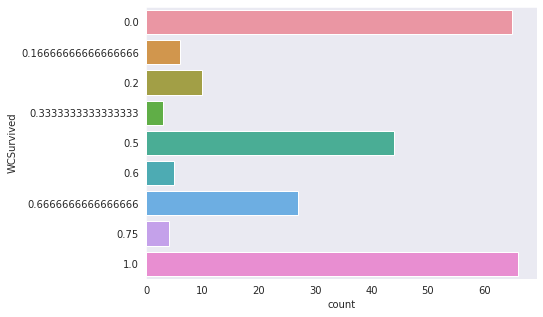

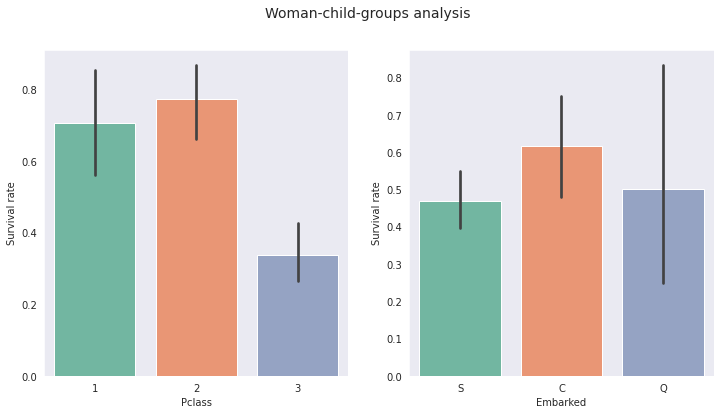

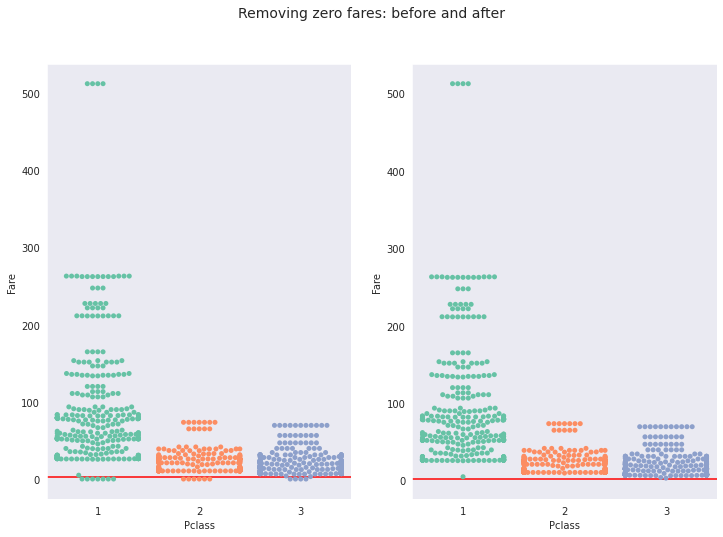

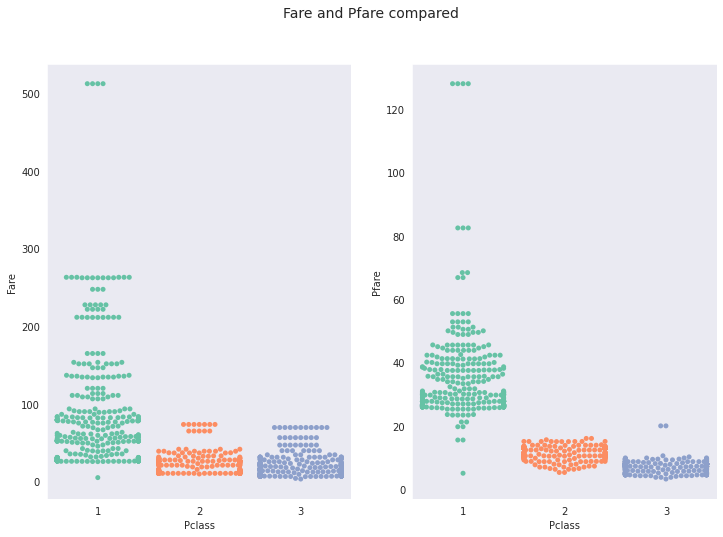

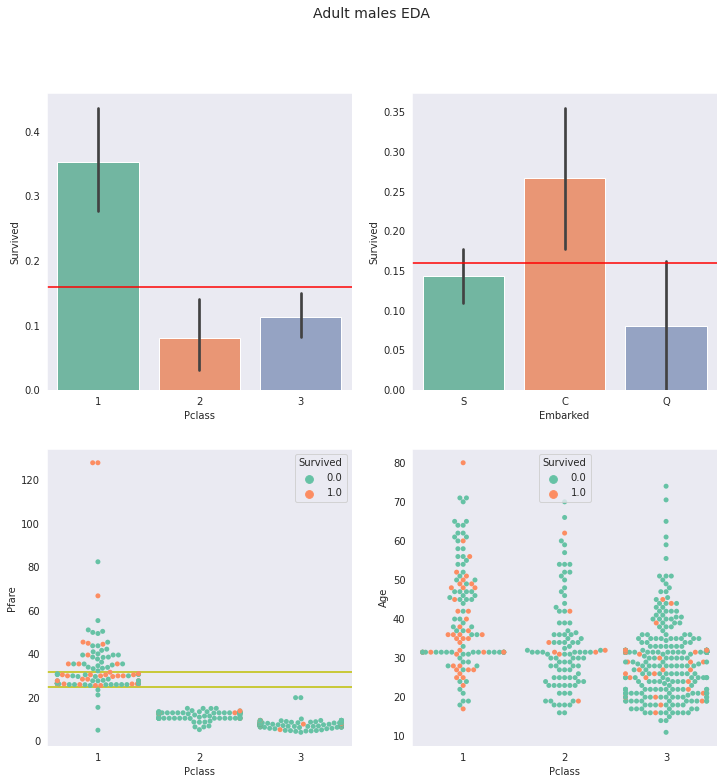

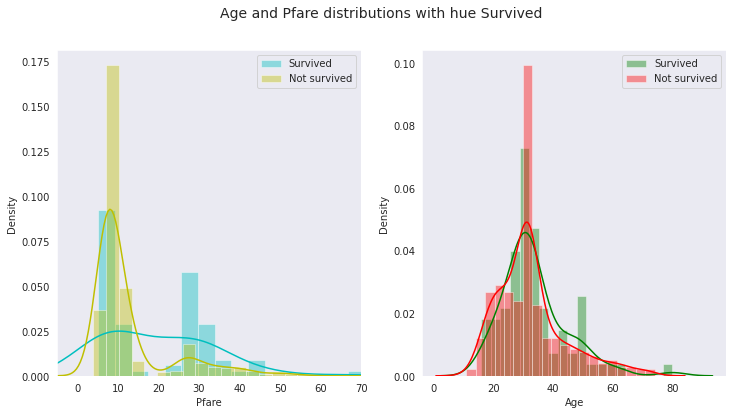

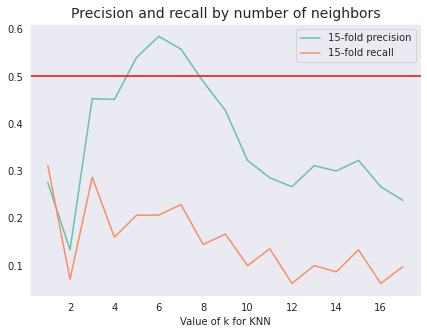

15-fold precision of the ensemble: 0.461
15-fold recall of the ensemble: 0.289
15-fold accuracy of the ensemble: 0.840

The following 9 adult males are predicted to live:


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 44.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 75.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 44.4% of the points cannot be placed; y

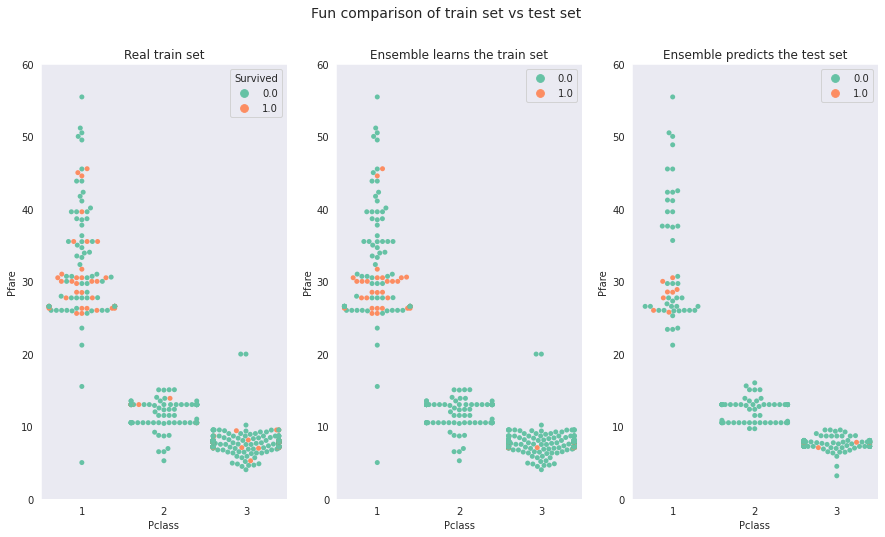

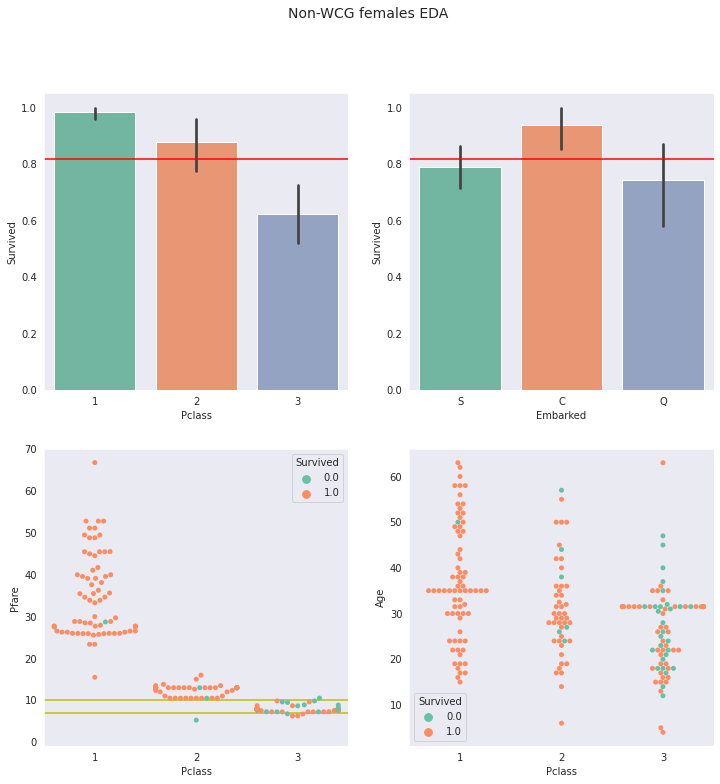

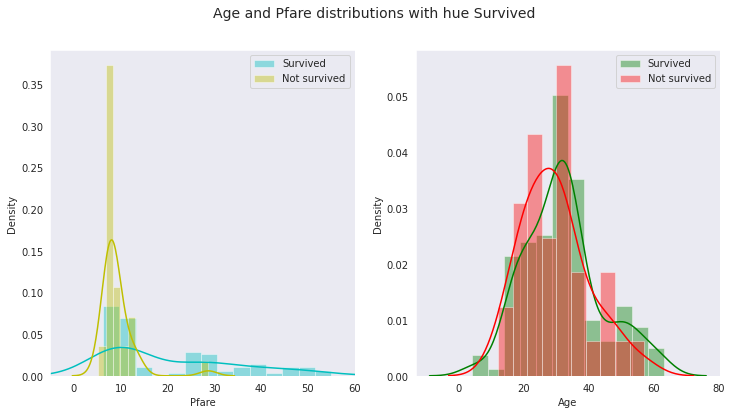

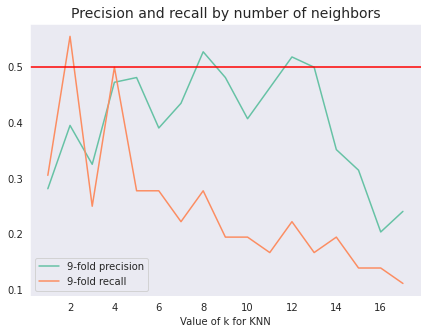

9-fold precision of the ensemble: 0.481
9-fold recall of the ensemble: 0.194
9-fold accuracy of the ensemble: 0.823

The following 6 non-WCG females are predicted to die:


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 50.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 50.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 52.2% of the points cannot be placed; y

"Wow! Our score increased again and it is now 82,8% which is 346 passengers, 2 more correct predictions than the WCG + adult males model!  \nUnfortunately, this is exactly the top score previously available so we were not able to make a breakthrough over 83%... or did we?  \nWell, we found some male survivors, that's a great win for me because this is something no one has ever succeeded doing and also indirectly is pushing the top score over its limit.      \nIf I had ensembled different models for non-WCG females (maybe including `Age` too), I could have probably scored over 83% but that's just an idea I leave here for the readers!  \n# Conclusion\nFirst of all, I would like to thank [Chris](https://www.kaggle.com/cdeotte) for his amazing Titanic tutorials as well as [Erik](https://www.kaggle.com/erikbruin) for his careful family analysis and `Fare` tricks which helped a bit.      \nSecondly, thank you for reading my notebook!  \nI hope you liked it: this was my attempt to push the to

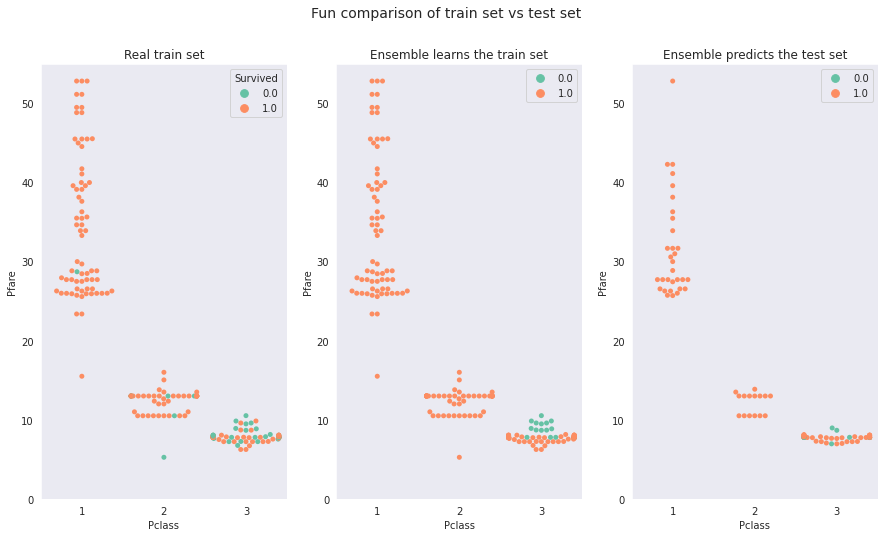

In [ ]:
# -*- coding: utf-8 -*-
"""May302100_0838_titanic_wcg_knns_ensemble_0_82775_top_1_ipynb_のコピー.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1xwyhqNkAAyUoPuUOysuuZNwI26Q4Fqeq

May301500との違いは947のみ

# Scoring over 83%, is it really possible?  
Two years have passed since Chris Deotte pushed the top score of the Titanic competition at 82,8% (note that this score is evaluated with the new 100% public leaderboard, previously it was 85,1%, for more info check the discussion [here](https://www.kaggle.com/c/titanic/discussion/179147)).  
For sure he did a great job and inspired lots of people, but is there a way to improve on his work?  
This notebook finds some adult male survivors with a simple approach, so definitely yes... but can we score over 83%?  
If you are new to the competition, I recommend you to play for a while with it and come back later, otherwise let's get started!
![](attachment:WCG%20pipeline-min.jpg)
"""

# Commented out IPython magic to ensure Python compatibility.
from google.colab import drive
#drive.mount('/content/drive')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
sns.set_style('dark')
sns.set_palette('Set2')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

"""We first load train and test data and join the two dataframes as it will be much easier to perform all our next operations."""

# 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
# データの読み込み方がわからない方は、別途配布している、GoogleColabにおけるドライブのマウントの仕方、と、Google Drive上でのフォルダ構造の説明のpdfファイルをご覧ください。
#train_url ='https://drive.google.com/uc?id=10CDxSTdXdtwysb3OLRg4Opj4WdKRBcvP'
#test_url = 'https://drive.google.com/uc?id=1hlbby9U7-ZYhGkl9E1jQ4Un1SFpqLJCJ'
#gender_url = 'https://drive.google.com/uc?id=1bHQBrIsnGawXqoSp6QqOt57oaDY81s_F'
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
#gender_submission = pd.read_csv(gender_url)
#df = pd.read_csv('drive/MyDrive/GCI/train.csv')
#df_test = pd.read_csv('drive/MyDrive/GCI/test.csv')

# testデータの'Perished'にNaNを埋めてtrainデータと接合する
df_test_column_added = df_test
df_test_column_added['Perished'] = np.NaN

df_combined_original = pd.concat([df,df_test_column_added])

# Ticket_frequency
df_passengerId_ticketFrequency_dict = df_combined_original.groupby('Ticket')['PassengerId'].count().to_dict()
df_passengerId_ticketFrequency_dict
df_combined_original['Ticket_frequency'] = df_combined_original['Ticket'].map(df_passengerId_ticketFrequency_dict)
df_combined_original['Adjusted_Fare'] = df_combined_original['Fare'] / df_combined_original['Ticket_frequency']

# Fareを　Adjusted_Fareに置き換える。
#df_combined_original['Fare'] = df_combined_original['Adjusted_Fare']

# 'Name'columnから姓(surname)と敬称(middle)を抽出
df_combined_name_splited = df_combined_original['Name'].str.split(',', expand=True)
df_combined_surname = df_combined_name_splited[0]
df_combined_middle = df_combined_name_splited[1].str.split('.', expand=True)[0]
df_combined_original['surname'] = df_combined_surname
df_combined_original['middle'] = df_combined_middle.str.strip()
df_combined = df_combined_original

# うち親または子の数がゼロでないレコード
df_with_Parch = df_combined.loc[ df_combined['Parch'] > 0, :]
df_with_Parch['middle'].drop_duplicates()
# うちMrs
df_Mrs = df_with_Parch.loc[df_with_Parch['middle'].str.contains('Mrs'), :]
df_Mrs['Family'] = 'mother'
df_Mrs['Age'].fillna(int(df_Mrs['Age'].mean()), inplace=True)

# うちMaster
df_Master = df_with_Parch.loc[df_with_Parch['middle'].str.contains('Master'), :]
df_Master['Family'] = 'child'
#print(df_Master['Age'].mean())
df_Master['Age'].fillna(int(df_Master['Age'].mean()), inplace=True)

# うちMiss
df_Miss = df_with_Parch.loc[df_with_Parch['middle'].str.contains('Miss'), :]
df_Miss['Family'] = 'child'
#print(max(df_Miss['Age']))
df_Miss['Age'].fillna(int(df_Miss['Age'].mean()), inplace=True)

# うちMr
df_Mr = df_with_Parch.loc[df_with_Parch['middle'].str.endswith('Mr'), :]
df_Mr['Family'] = 'father'
df_Mr['Age'].fillna(int(df_Mr['Age'].mean()), inplace=True)

# うちCapt
df_Capt = df_with_Parch.loc[df_with_Parch['middle'].str.endswith('Capt'), :]
df_Capt['Family'] = 'father'
df_Capt['middle'] = 'Mr'

# うちRev
df_Rev = df_with_Parch.loc[df_with_Parch['middle'].str.endswith('Rev'), :]
df_Rev['Family'] = 'father'

# うちDr
df_Dr = df_with_Parch.loc[df_with_Parch['middle'].str.endswith('Dr'), :]
df_Dr['Family'] = 'father'
df_Dr['middle'] = 'Mr'

df_with_Parch_age_added = pd.concat([df_Mrs, df_Master, df_Miss, df_Mr, df_Capt, df_Rev, df_Dr])

df_without_Parch = df_combined.loc[ df_combined['Parch'] == 0, :]

#うち　SibSp > 0
df_with_SibSp = df_without_Parch.loc[ df_without_Parch['SibSp'] > 0, :]
# うちMrs
df_Mrs_nc = df_with_SibSp.loc[df_with_SibSp['middle'].str.contains('Mrs'), :]
df_Mrs_nc['Family'] = 'wife'
df_Mrs_nc['Age'].fillna(int(df_Mrs_nc['Age'].mean()), inplace=True)
# うちMaster
df_Master_nc = df_with_SibSp.loc[df_with_SibSp['middle'].str.contains('Master'), :]
df_Master_nc['Family'] = 'child'
df_Master_nc['Age'].fillna(int(df_Master_nc['Age'].mean()), inplace=True)

# うちMiss
df_Miss_nc = df_with_SibSp.loc[df_with_SibSp['middle'].str.contains('Miss'), :]
df_Miss_nc['Family'] = 'child'
#print(max(df_Miss['Age']))
df_Miss_nc['Age'].fillna(int(df_Miss_nc['Age'].mean()), inplace=True)

# うちMr
df_Mr_nc = df_with_SibSp.loc[df_with_SibSp['middle'].str.endswith('Mr'), :]
df_Mr_nc['Family'] = 'husband'
df_Mr_nc['Age'].fillna(int(df_Mr_nc['Age'].mean()), inplace=True)

# うちRev
df_Rev_nc = df_with_SibSp.loc[df_with_SibSp['middle'].str.endswith('Rev'), :]
df_Rev_nc['Family'] = 'husband'

# うちDr
df_Dr_nc = df_with_SibSp.loc[df_with_SibSp['middle'].str.endswith('Dr'), :]
df_Dr_nc['Family'] = 'husband'
df_Dr_nc['middle'] = 'Mr'

# うちLady
df_Lady = df_with_SibSp.loc[df_with_SibSp['middle'].str.endswith('Lady'), :]
df_Lady['Family'] = 'child'
df_Lady['middle'] = 'Miss'

# うちSir
df_Sir = df_with_SibSp.loc[df_with_SibSp['middle'].str.endswith('Sir'), :]
df_Sir['Family'] = 'husband'

# うちCol
df_Col = df_with_SibSp.loc[df_with_SibSp['middle'].str.endswith('Col'), :]
df_Col['Family'] = 'husband'
df_Col['middle'] = 'Sir'

df_with_SibSp_age_added = pd.concat([df_Mrs_nc, df_Master_nc, df_Miss_nc, 
                                     df_Mr_nc, df_Rev_nc, df_Dr_nc,
                                     df_Lady, df_Sir, df_Col])

df_without_SibSp =  df_without_Parch.loc[ df_without_Parch['SibSp'] == 0, :]
df_without_SibSp['Family'] = 'without_SibSp'

# Age欠損値の補完

df_without_SibSp['Age'].fillna(df_without_SibSp.mean()['Age'], inplace=True)

# Adjusted_Fare欠損値の補完

df_without_SibSp_Fare_na_Pclass = df_without_SibSp.loc[df_without_SibSp['Adjusted_Fare'].isnull(),'Pclass'].iloc[0]
df_without_SibSp_Fare_na_Embarked = df_without_SibSp.loc[df_without_SibSp['Adjusted_Fare'].isnull(),'Embarked'].iloc[0]
df_same_Pclass = df_combined_original.loc[df_combined_original['Pclass'] == df_without_SibSp_Fare_na_Pclass, :]
df_same_Pclass_Embarked_Fare = df_same_Pclass.loc[df_same_Pclass['Embarked'] == df_without_SibSp_Fare_na_Embarked, 'Adjusted_Fare'].mean()
df_without_SibSp['Adjusted_Fare'].fillna(df_same_Pclass_Embarked_Fare, inplace=True)

df_without_SibSp_age_added = df_without_SibSp

df_age_added = pd.concat([df_with_Parch_age_added,
                          df_with_SibSp_age_added,
                          df_without_SibSp_age_added])

# Embarked欠損値の補完

df_age_added_Embarked_na_ticket = df_age_added.loc[df_age_added['Embarked'].isnull(),'Ticket'].iloc[0]
df_same_ticket = df_age_added.loc[df_age_added['Ticket'].str.startswith(df_age_added_Embarked_na_ticket[0:4]) ,'Embarked'].sort_values().iloc[0]
df_age_added['Embarked'].fillna(df_same_ticket, inplace=True)

# Cabinの頭文字抽出

df_age_added['FCabin']=df_age_added['Cabin'].str[0]
df_age_added['FCabin'].fillna('N', inplace=True)

df = df_age_added.loc[df_age_added['Perished'].notna()]
df_test = df_age_added.loc[ df_age_added['Perished'].isna()].drop(['Perished'], axis=1)

df['Survived'] = 1 - df['Perished']
df_test['Survived'] = 1 - df['Perished']
df.drop('Perished', axis = 1, inplace=True)

train_data = df
test_data = df_test

#train_data = pd.read_csv('../input/titanic/train.csv')
#test_data = pd.read_csv('../input/titanic/test.csv')
data = pd.concat([train_data, test_data]).reset_index().drop(['index'], axis=1)

"""# Woman-Child-Groups (WCG)
If we want to get the most accurate Titanic model ever, for sure we have to start with the best component available: let's code the final version of the WCG model developed by Chris in the first part of the [Titanic Mega Model](https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210).  
If you haven't already, check that notebook out because it is really clear and contains one dotplot visualization that explains the idea behind the grouping models.  
Just with the WCG model, we will achieve 81,6% (confirmed to be 83,7% in the old public leaderboard before the change) and we will then work our way to the top.  
The first thing to do is extract the surname from the `Name` column, as it will be essential in engineering a `Group_id` feature that precisely identifies families.  
"""

data['Surname'] = data['Name'].apply(lambda x: x.split(',')[0])

"""For each passenger, let's now concatenate the strings `Surname + Pclass + Ticket + Fare + Embarked` to have an alphanumeric one under the name `Group_id`.  
As proved in [this](https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting) notebook by Erik Bruin, sometimes tickets of passengers traveling together differ in their last digit, so let's also remove the last digit to be consistent and identify the largest number of groups (for example, the `Ticket` value 'CA. 2343' will become 'CA. 234').  
The other features such as `SibSp` and `Parch` are purposely not included in the `Group_id` because they contain errors and are not equal for every family component.  
The `Cabin` column is not included either because too much data is missing.  
Let's write a group_id function that does exactly what we need.  
We pass through a `Ticket_id` helper column that we will reuse later.
"""

# New Ticket_id column
data['Ticket_id'] = 'new_col'
# Initialize Ticket_id = Pclass + Ticket + Fare + Embarked
def ticket_id(row):
    row['Ticket_id'] = str(row.Pclass) + '-' + str(row.Ticket)[:-1] + '-' + str(row.Fare) + '-' + str(row.Embarked)
    return row

data = data.apply(ticket_id, axis='columns')

# New Group_id column
data['Group_id'] = 'new_col2'
# Initialize Group_id = Surname + Ticket_id
def group_id(row):
    row['Group_id'] = str(row.Surname) + '-' + str(row.Ticket_id)
    return row

data = data.apply(group_id, axis='columns')

"""Now we divide the passengers into three categories: men, women and children (only male ones).  
From the latter two, WCG will be created and we will assign a survival rate to the group so we can make predictions for each member in case he/she is in the test data.
"""

# creation of the Title feature
data['Title'] = 'man'
data.loc[data.Sex == 'female', 'Title'] = 'woman'
data.loc[data['Name'].str.contains('Master'), 'Title'] = 'boy'

"""We now assign the label 'noGroup' to every man and count the frequency for each `Group_id` element of the dataframe in the new `WC_count` column.  
We will then assign 'noGroup' also to every woman or child whose `Group_id` value is unique (i.e. with frequency one) in the entire dataframe.
"""

data.loc[data.Title == 'man', 'Group_id'] = 'noGroup'
# New column with WC frequency
data['WC_count'] = data.loc[data.Title != 'man'].groupby('Group_id')['Group_id'].transform('count')
# assign noGroup to every unique value
data.loc[data.WC_count <=1, 'Group_id'] = 'noGroup'

"""Now a great idea, which definitely helps: adding relatives to the groups we identified so far.  
What characteristics do these people share with the other group members?  
Well, they have a different `Surname` but all the other entries are equal, so they have the same `Ticket_id`.  
Let's see an example.
"""

cols = ['PassengerId', 'Survived', 'Name', 'Title', 'Ticket_id','Group_id']
#cols = ['PassengerId', 'Survived', 'Name', 'Title', 'Ticket_id','Group_id',"middle"]
data.loc[(data.Ticket_id == '1-1696-134.5-C') & (data.Title != 'man'), cols]

"""All these people have the same `Pclass`, `Fare`, `Embarked` and `Ticket` number, but two of them are considered part of any group: this is what we are going to fix.  
So let's search for these alone women (or children) which are most likely part of an already existing group.  
We loop through all the passengers whose `Group_id` is 'noGroup' and who are not adult males: if we find that their `Ticket_id` value occurs in an existing group, we change the passenger's `Group_id` entry.
"""

indices = []
count = 0
for i in range(0,1309):
    if (data.loc[i,'Title'] != 'man') & (data.loc[i,'Group_id'] == 'noGroup'):
        data.loc[i,'Group_id'] = data.loc[(data['Ticket_id'] == data.loc[i, 'Ticket_id']) & (data.Title != 'man'), 'Group_id'].iloc[0]
        if (data.loc[i, 'Group_id'] != 'noGroup'):
            indices.append(i)
            count += 1
print('{:d} passengers were added to an existing group'.format(count))

"""And here we are, 11 passengers were added to a group. Let's see them."""

cols = ['PassengerId', 'Survived', 'Name', 'Title', 'Group_id']
data.loc[indices, cols]

"""It looks like 9 of those 11 passengers are in the test data, so there is definitely the possibility to find other females who died, nice!  
Just to understand how many passengers are part of a group, let's make a quick analysis.
"""

number_of_groups = data.loc[data.Group_id != 'noGroup', 'Group_id'].nunique()
print('Number of groups found: {:d}'.format(number_of_groups))
number_of_WCG_passengers = data.loc[data.Group_id != 'noGroup', 'Group_id'].count()
print('\nNumber of passengers in a group: {:d}'.format(number_of_WCG_passengers))
composition = data.loc[data.Group_id != 'noGroup','Title'].value_counts()
print('\nComposition of the groups:')
print(composition.to_string())

"""So we found 80 woman-child-groups, for a total of 230 passengers: 171 women and 59 boys.  
Let's move on to the central aspect of this approach: calculate the average survival rate of each group.  
Here is how it is done: we simply group by `Group_id` and evaluate the mean for the known `Survived` values.
"""

data['WCSurvived'] = data.loc[(data.Title != 'man') & (data.Group_id != 'noGroup')].groupby('Group_id').Survived.transform('mean')

"""Now we have something like this: if a group has both passengers in the train and test data, the second ones have an associated `WCSurvived` value that is the mean of the `Survived` values in the train data for that particular group."""

cols = ['PassengerId', 'Survived', 'WCSurvived', 'Name', 'Title', 'Group_id']
data.loc[data.Group_id == 'Sage-3-CA. 234-69.55-S', cols]

"""We can understand the power of this approach now if we look at all the values that `WCSurvived` assumes."""

print('WCSurvived all data values:')
print(data.WCSurvived.value_counts().to_string())
plt.figure(figsize=(7,5))
f = sns.countplot(y=data.WCSurvived)

"""The unique values count confirms that generally the assumption that these groups lived or perished together is absolutely correct: that is the real power of the WCG model.  
Only 11 people have a non-integer `WCSurvived` value: the Allisons and the Asplunds.  
We see that most of them are in the train data, so for the only three people in the test set we will just use the gender model and hope for the best.  
"""

data.loc[(data.WCSurvived==0.75) | (data.WCSurvived==0.5), cols].sort_values(by='Group_id')

"""We are not done yet as there are some family groups with all members in the test data.  
For this reason, they have an unknown family survival rate, but we will assume that every component of the family underwent the same fate as our WCG hypothesis.
"""

# Get the family names using set difference
test_groups = set(data[891:1309].Group_id.unique()) - set(data[0:891].Group_id.unique())
data.loc[data.Group_id.isin(test_groups), cols].sort_values(by='Group_id')

"""These families are the Gibsons, Klasens, Peacocks, van Billiards.  
We need to make predictions for them so let's explore which woman-child-groups live or die.
"""

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Woman-child-groups analysis', fontsize=14)
a = sns.barplot(x='Pclass', y='Survived', data=data[data.Group_id != 'noGroup'], ax=ax[0]).set_ylabel('Survival rate')
b = sns.barplot(x='Embarked', y='Survived', data=data[data.Group_id != 'noGroup'], ax=ax[1]).set_ylabel('Survival rate')

"""From this analysis, we immediately see that woman-child-groups traveling in `Pclass` 1 or 2 mostly survived and woman-child-groups in `Pclass` 3 mostly perished.  
Since the Gibsons had `Pclass` 1 and `Embarked` C while the Klasens, Peacocks, and van Billiards had `Pclass` 3 and `Embarked` S, our best bet is to assume that the Gibsons survived and the other three families died.
"""

# Assign WCSurvived = 0 to 3rd class test families, else 1
data.loc[data.Group_id.isin(test_groups), 'WCSurvived'] = 0
data.loc[(data.Group_id.isin(test_groups)) & (data.Pclass != 3), 'WCSurvived'] = 1

"""Now, this is the total number of passengers in the test set by `WCSurvived` value: we are finally ready to make predictions."""

print('WCSurvived test values:')
print(data[891:1309].WCSurvived.value_counts().to_string())

"""## Make WCG predictions and submission to Kaggle
There are 74 passengers part of a woman-child-group in the test dataset.  
Let's apply these two prediction rules on top of the gender model which simply predicts that all men (including children) die while all women live: 
* Predict die for all females whose entire family, excluding adult males, all die as indicated by the `WCSurvived` column equaling 0  
* Predict live for all boys whose entire family, excluding adult males, all live as indicated by the `WCSurvived` column equaling 1
"""

# Set everyone to 0
data.loc[891:1308, 'Predict'] = 0
# Set women to 1, completing the gender model
data.loc[891:1308, 'Predict'][(data.Sex == 'female')] = 1
# Change WCG women with WCSurvived=0 to 0
data.loc[891:1308,'Predict'][(data.Sex == 'female') & (data['WCSurvived'] == 0)] = 0
# Change WCG boys with WCSurvived=1 to 1, completing the WCG + gender model
data.loc[891:1308, 'Predict'][(data.Title == 'boy') & (data['WCSurvived'] == 1)] = 1
# With this, the three group members with non-integer WCSurvived are not changed from the gender model

# Class3の6人グループの中国人を生存に変更
data.loc[891:1308, 'Predict'][(data.Ticket_frequency == 6) & (data['Pclass'] == 3)] = 1

"""Here is a summary of which passengers are predicted to live or die from the previous prediction rules."""

print('The following 8 males are predicted to live:')
cols = ['PassengerId', 'Name', 'Title', 'Group_id']
data[891:1309][cols].loc[(data.Title == 'boy') & (data.Predict == 1)]

print('The following 15 females are predicted to die:')
data[891:1309][cols].loc[(data.Title == 'woman') & (data.Predict == 0)]

print('The remaining 258 males are predicted to die')
print('and the remaining 137 females are predicted to live')

"""Now we submit the predictions to the leaderboard: at the time I first tried doing this, the old leaderboard with only 50% of test data was still in use.  
However, now that I am publishing the notebook, there is the new one that uses all of the test data to calculate the score and it appears that they are lower as much as 2% (reason explained [here](https://www.kaggle.com/c/titanic/discussion/179147)).
"""

output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
#output.to_csv('WCG_gender.csv', index=False)
#print('WCG_gender submission was successfully saved!')
#print('Submission is loading... you scored 81,6%!')

"""Nice, as good as we expected!  
This extremely simple woman-child-group model scores 81,6% in the new and current leaderboard (341 correct predictions) which is really impressive.  
Considering that the gender submission scores 76,5% (which is 320 correct predictions) and this model changes 23 of them, it means 22/23 are correct!  
With the old leaderboard, I confirm that it was 83,7% so definitely not bad.
# Non-WCG passengers
For the second part of this notebook, we will focus on non-WCG passengers, who are adult males on one side and females who are not part of an existing group on the other.  
## Fixing the Fare column
Before starting we will do a couple of things.  
First of all, we fix rows with a `Fare` amount of 0 assigning them a null value that will be imputed later when we come to modeling.  
As pointed out by Erik Bruin [here](https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting), the information might be correct (a quick research showed for example that some of them were part of the guarantee group), but the zero-fares might confuse the algorithms as most of them are within the 1st and 2nd class passengers.  
In this notebook, I actually ended up using KNNs so this preprocessing makes no difference, but if I wanted to use something else this may help and that's why I leave it.
"""

# Assign np.NaN to zero-fares
def fix_fare(row):
    if row.Fare == 0:
        row.Fare = np.NaN
    return row
print('The following {:d} passengers have a zero Fare:'.format(data[data.Fare==0].shape[0]))
cols = ['PassengerId', 'Survived', 'Pclass','Fare', 'Name']
data.loc[data.Fare==0, cols]

"""Here you can see the difference before and after removing zero fares.  """

fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle('Removing zero fares: before and after', fontsize=14)
a = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[0])
ax[0].axhline(y=2, color='r')
# Apply the fix_fare function 
data = data.apply(fix_fare, axis='columns')
ax[1].axhline(y=2, color='r')
b = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[1])

"""Next, we modify the `Fare` column another time to create the `Pfare` feature that is just a passenger's `Fare` divided by his ticket frequency.  
This mostly helps in reducing the range of the `Fare` feature and also fixes some outliers.  
Again, here you find the difference before and after: note the scale difference on the y-axis.
"""

# Calculate Ticket frequency and divide Fare by it
data['Ticket_freq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['Pfare'] = data['Fare'] / data['Ticket_freq']

fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle('Fare and Pfare compared', fontsize=14)
a = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[0])
b = sns.swarmplot(x='Pclass', y='Pfare', data=data, ax=ax[1])

"""As you can see, the range is reduced from over 500 to 125, the second class is now more compact and the third class lost most of its outliers with really high fares.  
With these two small tweaks, we are now ready to go.
## Explore adult males
Adult males are the most difficult category to make predictions for.  
Most of the models we see here on Kaggle predict that all of them die and if not, usually the results are not satisfactory.  
Here my idea seems to work, even if not with magnificent results: let's dive into it.
"""

# Isolating adult males in train and test set
train_male = data[0:891].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]
test_male = data[891:1309].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]

"""Now let's perform a short analysis to see what features might be useful considering.  
In red I plotted the average survival rate for adult males in the train data.
"""

fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Adult males EDA', fontsize=14)
sns.barplot(x='Pclass', y='Survived', data=train_male, ax=ax[0][0])
ax[0][0].axhline(y=train_male.Survived.mean(), color='r')
sns.barplot(x='Embarked', y='Survived', data=train_male, ax=ax[0][1])
ax[0][1].axhline(y=train_male.Survived.mean(), color='r')
sns.swarmplot(x='Pclass', y='Pfare', hue='Survived', data=train_male, ax=ax[1][0])
ax[1][0].axhline(y=25, color='y')
ax[1][0].axhline(y=32, color='y')
a = sns.swarmplot(y='Age', x='Pclass', hue='Survived', data=train_male, ax=ax[1][1])

"""We draw some interesting conclusions: `Pclass` is definitely useful and also `Embarked`, even though these two features are not independent (see why if you didn't know this).  
What about `Pfare`? We see there is a nice concentration of orange dots in the first class with `Pfare` between 25 and 32 (almost 50%), so this may be our best chance to guess some male survivors.  
What about `Age` instead? We recognize that the value of `Pclass` is the most discriminative because `Age` alone is very confusing (try tracing two horizontal lines as we did for `Pfare`).  
Let's see the distributions of the two numerical features to understand their influence on the target variable.
"""

x1 = train_male.loc[train_male['Survived']==1, 'Pfare']
x0 = train_male.loc[train_male['Survived']==0, 'Pfare']
y1 = train_male.loc[train_male['Survived']==1, 'Age']
y0 = train_male.loc[train_male['Survived']==0, 'Age']

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Age and Pfare distributions with hue Survived', fontsize=14)
sns.distplot(x1, bins=30, label = 'Survived', ax = ax[0], color = 'c')
sns.distplot(x0, bins=25, label = 'Not survived', ax = ax[0], color = 'y')
ax[0].set_xlim(-5, 70)
ax[0].legend()
sns.distplot(y1, bins=20, label = 'Survived', ax = ax[1], color = 'g')
sns.distplot(y0, bins=20, label = 'Not survived', ax = ax[1], color = 'r')
ax[1].legend()
fig.show()

"""We notice the `Age` distributions mostly overlap, while the `Pfare` ones do not (note the different height).  
So, is it leaving out `Age` the correct choice? I think yes.
## Let's build an ensemble
What information can we extract from the `Pfare`, `Pclass`, `Embarked` columns?  
Are they enough to detect some male survivors?  
Let's build an ensemble of three models and we will see!  
I used only K-Nearest Neighbors just to have fun: it may not be the best choice (and I am pretty sure about that) but I encourage you to fork this notebook and try your models.  
Since the classes are very imbalanced (the deads are more than 5 times the survivors), accuracy might not be a good metric here: for example, cross-validation accuracy for the predict all die model is 0.84!  
We are interested in precision and recall instead, i.e. respectively how many of the samples predicted as survivors actually lived and how many survivors are captured by our positive predictions.
![](attachment:precision-recall-min.jpg)
*Image by Walber - Own work, CC BY-SA 4.0, [link](https://commons.wikimedia.org/w/index.php?curid=36926283).*  

Since the survivors are very spread out, we don't expect our model to have a high recall but we would like to have a decent precision for sure.  
Note that with respect to these two metrics, the predict all die model has a score of 0.0 and 0.0!  
Let's see how these two metrics vary in a KNN model when we change the number of neighbors.
"""

train_male['isRev'] = 0
train_male.loc[train_male['middle']=='Rev','isRev'] = 1
test_male['isRev'] = 0
test_male.loc[test_male['middle']=='Rev','isRev'] = 1

cols = ['PassengerId', 'Name', 'Pfare', 'Pclass', 'Embarked']
cols_m = ['PassengerId', 'Name', 'Pfare', 'Pclass', 'Embarked', 'isRev']
y_m = train_male['Survived']
features = ['Pfare', 'Pclass', 'Embarked']
features_m = ['Pfare', 'Pclass', 'Embarked', 'isRev']
#X_m = train_male[features_m]
X_m = train_male[features]

numerical_cols = ['Pfare']
categorical_cols = ['Pclass', 'Embarked']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

precision_m = []
recall_m = []

for k in range(1,18):
    pipeline1 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    precision_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean())
    recall_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean())
    
k_range = range(1,18)
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_m, label='15-fold precision')
plt.plot(k_range, recall_m, label='15-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

"""We see that an even or odd number of neighbors makes a significant difference in the recall score, while the precision has a nice trend almost independent from the parity.  
It is interesting to see that even when the recall is approximately zero, the models maintain a non-zero precision (even though they are pretty useless).  
Let's select our three values for k in the ensemble to be 1, 3 and 7.  
The reason is that the first two are supposed to detect most of the male survivors with a decent recall while the latter is a pretty good model on his own that will improve the total precision.  
I know this is a completely naive approach to an ensemble but forgive me for this!
"""

m1 = KNeighborsClassifier(n_neighbors=1)
m2 = KNeighborsClassifier(n_neighbors=3)
m3 = KNeighborsClassifier(n_neighbors=7)
# Preprocessing is the same as before
male_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting',VotingClassifier([
        ('m1', m1), ('m2', m2), ('m3', m3)]))
])
print('15-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean()))
print('15-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean()))
print('15-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1).mean()))
# Fit model and make predictions
male_pipeline.fit(X_m, y_m)
learn_train_m = male_pipeline.predict(X_m)
#X_test_m = test_male[features_m]
X_test_m = test_male[features]
predictions_m = male_pipeline.predict(X_test_m)
print('\nThe following 9 adult males are predicted to live:')
test_male.loc[(predictions_m==1), cols_m]

"""The 15-fold precision of the ensemble is 0.562, slightly better than 0.5 and in between the original precisions of the three models.  
I know finding some male survivors is a difficult task, so obtaining this >0.5 accuracy is a good result for me.  
Unfortunately, the 15-fold recall of the ensemble is only 0.318 but at least it did not go down from the original recalls of the three models.  
That is a consequence of the sparsity of the survivors, especially in the second and third classes where our model was not able to extract useful patterns (except one, Mr. Ling Hee in the third class!).  
Since we made 9 predictions, there is a concrete possibility that we find some male survivors this time!  
Just for fun, here I compare the train set, how the ensemble learns it and its predictions for the test data.
"""

fig, ax = plt.subplots(1,3,figsize=(15,8))
fig.suptitle('Fun comparison of train set vs test set', fontsize=14)
ax[0].set_title('Real train set')
ax[0].set_ylim(top=60)
sns.swarmplot(x=X_m.Pclass, y=X_m.Pfare, hue=y_m, ax=ax[0])
ax[1].set_title('Ensemble learns the train set')
ax[1].set_ylim(top=60)
sns.swarmplot(x=X_m.Pclass, y=X_m.Pfare, hue=learn_train_m,  ax=ax[1])
ax[2].set_title('Ensemble predicts the test set')
ax[2].set_ylim(top=60)
a = sns.swarmplot(x=test_male.Pclass, y=test_male.Pfare, hue=predictions_m,  ax=ax[2])

"""## Submission to Kaggle
Let's change the adult male predictions of the ensemble from the gender model and submit.  
An advantage of the new 100% public leaderboard is that we have now the possibility to count exactly how many correct predictions we make.
"""

data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull())] = predictions_m
output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
#output.to_csv('WCG_male.csv', index=False)
#print('WCG_male submission was successfully saved!')
#print('Submission is loading... you scored 82,3%!')

"""Wow, we scored 82,3% which is 344 passengers, 3 more correct predictions than the WCG + gender model!  
It means 6 out of our 9 male predictions were correct: we finally found a way to guess some male survivors, yeah!
## Explore non-WCG females
Non-WCG females are a very wide group which contains solo females but also women traveling with their spouse.  
A way to isolate them from the dataframe is of course select null `WCSurvived` entries from the female subpopulation.
"""

train_female = data[0:891].loc[(data.Sex=='female')  & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]

"""As we did before, let's run a quick analysis to see if we can use more features or if `Age` is again not useful."""

fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Non-WCG females EDA', fontsize=14)
sns.barplot(x='Pclass', y='Survived', data=train_female, ax=ax[0][0])
ax[0][0].axhline(y=train_female.Survived.mean(), color='r')
sns.barplot(x='Embarked', y='Survived', data=train_female, ax=ax[0][1])
ax[0][1].axhline(y=train_female.Survived.mean(), color='r')
sns.swarmplot(x='Pclass', y='Pfare', hue='Survived', data=train_female, ax=ax[1][0])
ax[1][0].set_ylim(top=70)
ax[1][0].axhline(y=7, color='y')
ax[1][0].axhline(y=10, color='y')
a = sns.swarmplot(y='Age', x='Pclass', hue='Survived', data=train_female, ax=ax[1][1])

"""For non-WCG females, we definitely see that `Pclass` will be determinant another time and that we have to focus on third-class because the survival rates elsewhere are really high.  
We see there is a decent concentration of green dots in the third class with `Pfare` between 7 and 10, so this may be our best chance to guess some females who died.  
Let's see `Age` and `Pfare` distributions to understand their importance.
"""

w1 = train_female.loc[train_female['Survived']==1, 'Pfare']
w0 = train_female.loc[train_female['Survived']==0, 'Pfare']
z1 = train_female.loc[train_female['Survived']==1, 'Age']
z0 = train_female.loc[train_female['Survived']==0, 'Age']

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Age and Pfare distributions with hue Survived', fontsize=14)
sns.distplot(w1, bins=35, label = 'Survived', ax = ax[0], color = 'c')
sns.distplot(w0, bins=15, label = 'Not survived', ax = ax[0], color = 'y')
ax[0].set_xlim(-5, 60)
ax[0].legend()
sns.distplot(z1, bins=12, label = 'Survived', ax = ax[1], color = 'g')
sns.distplot(z0, bins=10, label = 'Not survived', ax = ax[1], color = 'r')
ax[1].legend()
fig.show()

"""We notice `Age` is again not really astonishing while `Pfare` is the one which will help us the most.  
Let's try not to use `Age` and hope for the best: we already found some male survivors so we are more than happy with the result.
## Let's build an ensemble, again
We will make our predictions through an ensemble of three models, using KNNs just for fun.  
I encourage you to fork this notebook and try your models if you don't like this choice!  
Since the classes are very imbalanced another time (the survivors are 4.5 times the deads), accuracy is not a good metric here: for example, cross-validation accuracy for the predict all live model is 0.818!  
Since sklearn metrics use 1 as the default value for positive samples, we have to create our custom metrics that use 0 as the positive value.
"""

from sklearn.metrics import make_scorer, precision_score, recall_score
# We set zero_division=0 to avoid raising errors
custom_precision = make_scorer(precision_score, pos_label=0, zero_division=0)
custom_recall = make_scorer(recall_score, pos_label=0)

"""Again, we don't expect our model to have a high recall but we would like to have a decent precision.  
Note that with respect to these two custom metrics, the predict all live model has a score of 0.0 and 0.0!  
Let's vary the number of neighbors in a KNN model and see how these two quantities change.
"""

y_f = train_female['Survived']
X_f = train_female[features]
precision_f = []
recall_f = []
# Preprocessing is always the same...
for k in range(1,18):
    pipeline2 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    # We use 9-fold because the train size is smaller
    # and 198/9 = integer
    precision_f.append(cross_val_score(pipeline2, X_f, y_f, cv=9, n_jobs=-1, scoring=custom_precision).mean())
    recall_f.append(cross_val_score(pipeline2, X_f, y_f, cv=9, n_jobs=-1, scoring=custom_recall).mean())
    
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_f, label='9-fold precision')
plt.plot(k_range, recall_f, label='9-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

"""Oh, what a strange plot!  
We see the effect of parity is huge, that it takes a while to increase accuracy over 0.5 and that we have to lose almost half of the recall to gain that.  
This time, precision and recall also go to zero at the same time which is a cool thing.  
I'll try to select the KNN models with k values of 4, 9, 11 with a similar logic as before: we take the high recall of the first, we combine it to the high precision of the second and we add the third that has a little bit of both.  
Let's see how it goes...
"""

f1 = KNeighborsClassifier(n_neighbors=4)
f2 = KNeighborsClassifier(n_neighbors=9)
f3 = KNeighborsClassifier(n_neighbors=11)
# Preprocessing pipelines are the same as before
female_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting', VotingClassifier([
        ('f1', f1), ('f2', f2), ('f3', f3)]))
])
print('9-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9, scoring=custom_precision).mean()))
print('9-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9, scoring=custom_recall).mean()))
print('9-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9).mean()))
# Preprocessing of training data, fit model
female_pipeline.fit(X_f, y_f)
learn_train_f = female_pipeline.predict(X_f)
X_test_f = test_female[features]
predictions_f = female_pipeline.predict(X_test_f)
print('\nThe following 6 non-WCG females are predicted to die:')
test_female.loc[(predictions_f==0), cols]

"""Wow, the 9-fold precision for the ensemble is 0.571, at least it did not go down!  
The recall isn't great but it's ok, also this one is a difficult task and we don't expect a lot more than this.      
I'm surprised that we made only 6 predictions, but it is what it is with such a small test set (only 97 rows).  
As I did before, here I compare the train set, how the ensemble learns it and its predictions for the test data.  
Thanks to this plot, we can also see that non-WCG females in the third class are not distributed as in the train data and this may explain why we made only a few predictions.  
"""

fig, ax = plt.subplots(1,3,figsize=(15,8))
fig.suptitle('Fun comparison of train set vs test set', fontsize=14)
ax[0].set_title('Real train set')
ax[0].set_ylim(top=55)
sns.swarmplot(x=X_f.Pclass, y=X_f.Pfare, hue=y_f, ax=ax[0])
ax[1].set_title('Ensemble learns the train set')
ax[1].set_ylim(top=55)
sns.swarmplot(x=X_f.Pclass, y=X_f.Pfare, hue=learn_train_f,  ax=ax[1])
ax[2].set_title('Ensemble predicts the test set')
ax[2].set_ylim(top=55)
a = sns.swarmplot(x=test_female.Pclass, y=test_female.Pfare, hue=predictions_f,  ax=ax[2])

"""It's actually pretty funny to see how the ensemble learns the train set but hey, if it works I keep it!
## Final Submission
Now it's time to see if we have a good model that predicts which females die.  
Hopefully, we have the same increment as before and have the best Titanic model ever!  
Let's change these female predictions from the previous model and submit to Kaggle.
"""

data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = predictions_f
output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
#output.to_csv('WCG_male_female.csv', index=False)

# Google Drive・Google Colaboratoryで作業する場合
output.sort_values(by = 'PassengerId', inplace=True)
output['Perished'] = 1 - output['Survived']
output.drop('Survived', axis = 1, inplace=True)
output.to_csv('May30_submission.csv',index=False, encoding = 'utf-8')

#from google.colab import files
#files.download('submission.csv')

"""Wow! Our score increased again and it is now 82,8% which is 346 passengers, 2 more correct predictions than the WCG + adult males model!  
Unfortunately, this is exactly the top score previously available so we were not able to make a breakthrough over 83%... or did we?  
Well, we found some male survivors, that's a great win for me because this is something no one has ever succeeded doing and also indirectly is pushing the top score over its limit.      
If I had ensembled different models for non-WCG females (maybe including `Age` too), I could have probably scored over 83% but that's just an idea I leave here for the readers!  
# Conclusion
First of all, I would like to thank [Chris](https://www.kaggle.com/cdeotte) for his amazing Titanic tutorials as well as [Erik](https://www.kaggle.com/erikbruin) for his careful family analysis and `Fare` tricks which helped a bit.      
Secondly, thank you for reading my notebook!  
I hope you liked it: this was my attempt to push the top score higher and even if I did not succeed, it was still a nice journey.  
I had to look at the problem from another perspective and not using the `Age` column ended up being a way to find some male survivors, so at least I made an important contribution.  
This notebook proves another time that the two tasks of predicting adult male survivors and females not in a group who died are very different and it is really difficult to do both well with the same approach.  
I believe it is possible to increase the public score again ensembling this model with others, mostly to correct some of the female predictions: I think the maximum score achievable could be around 350 passengers, which is 83,7%.  
That being said, I finish this notebook with a short summary of what we did.
# Summary of what we did
This notebook proved that male survivors can be found with simple elements and thus the old top scores have the potential to be improved, especially if we use the WCG model as a strong baseline.  
Here's the pipeline we followed to reach top 1% in the competition and an histogram of Titanic LB scores in September 2020.
![](attachment:Titanic_LB.png)
First, the passengers (train + test) were divided into four groups:
1. Adult males - 60% of the population (A)
1. Young boys (with Master title) - 5% of the population (B)
1. Females that have children, sisters, or mothers (brothers and husbands are optional) - 13% of the population (C)
1. Females that have brothers, or husbands (no children, no sisters, no mothers) or are traveling alone - 22% of the population (D)

Next, we built 3 classifiers:
1. **WCG** on top of the **gender model** to classify (B) + (C)
1. **Ensemble_1** of KNNs to classify (A)
1. **Ensemble_2** of KNNs to classify (D)

Finally we assembled the models. Here are the public scores:
1. **WCG + gender model** scores 81,6% which is 341 correct predictions
1. **WCG + ensemble_1 + all females live** scores 82,3% which is 344 correct predictions
1. **WCG + ensemble_1 + ensemble_2** scores 82,8% which is 346 correct predictions

See you soon in the next one and good luck passing 83%!  
Please let me know down in the comments your suggestions or if you find errors in the code!
"""

#data[data['Ticket_frequency']==6][data['Pclass']==3]



# Data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

11 passengers were added to an existing group
Number of groups found: 80

Number of passengers in a group: 230

Composition of the groups:
woman    171
boy       59
WCSurvived all data values:
1.000000    66
0.000000    65
0.500000    44
0.666667    27
0.200000    10
0.166667     6
0.600000     5
0.750000     4
0.333333     3
WCSurvived test values:
0.000000    21
0.500000    20
1.000000    14
0.666667    11
0.750000     2
0.333333     2
0.200000     2
0.166667     1
0.600000     1
The following 8 males are predicted to live:
The following 15 females are predicted to die:
The remaining 258 males are predicted to die
and the remaining 137 females are predicted to live
The following 17 passengers have a zero Fare:


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 32.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 67.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 84.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 32.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 67.9% of the points cannot be placed; y

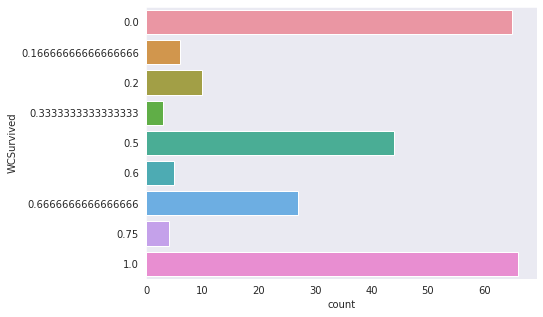

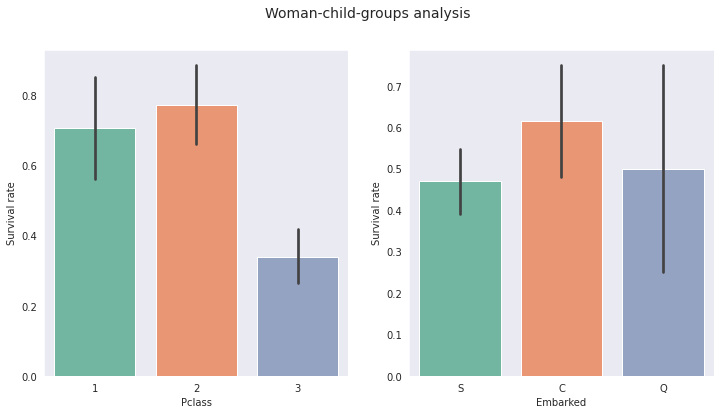

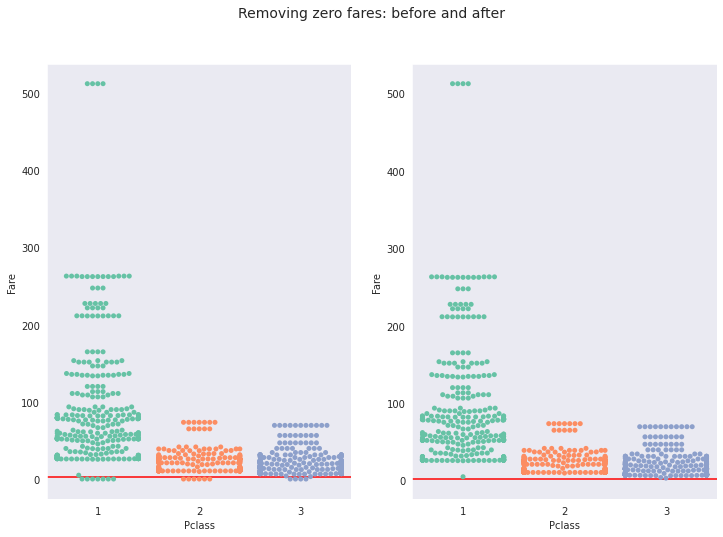

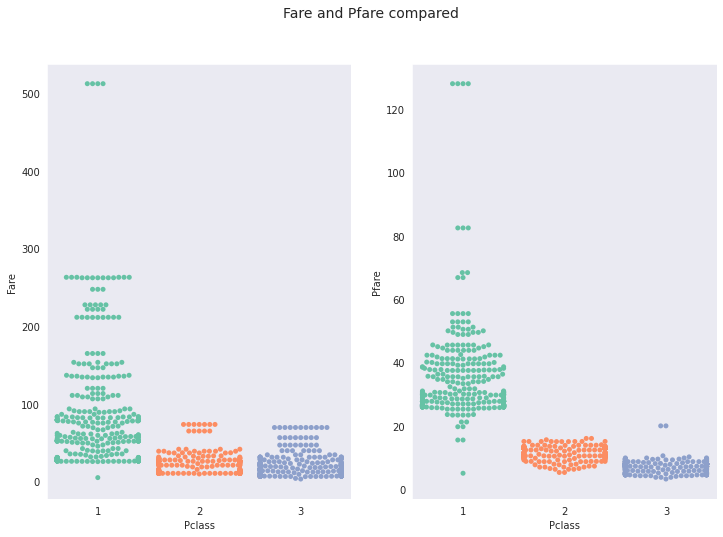

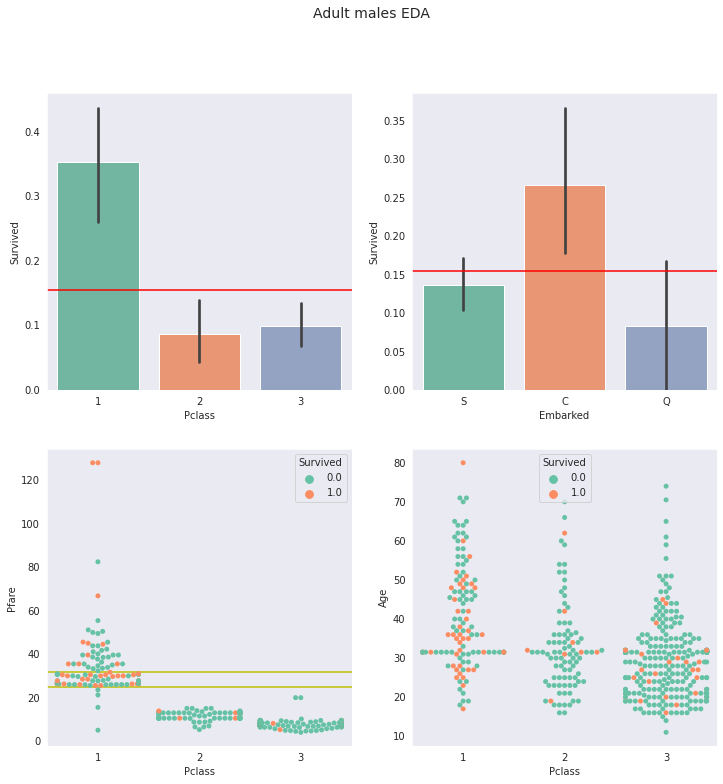

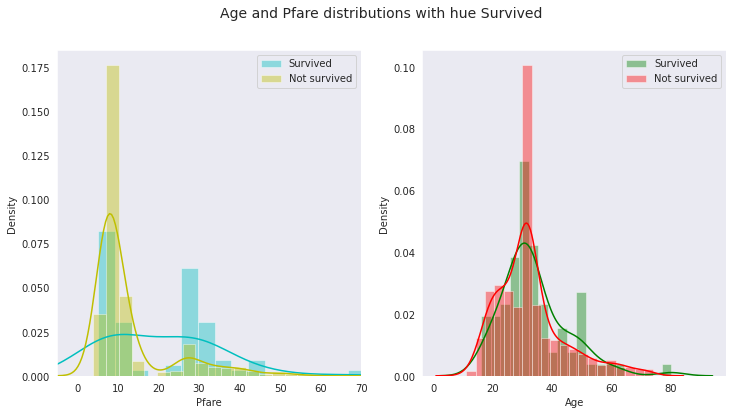

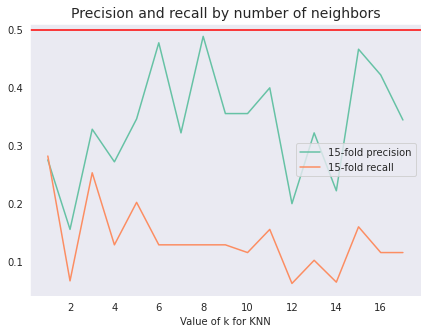

15-fold precision of the ensemble: 0.319
15-fold recall of the ensemble: 0.178
15-fold accuracy of the ensemble: 0.807

The following 9 adult males are predicted to live:


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 43.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 75.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 43.0% of the points cannot be placed; y

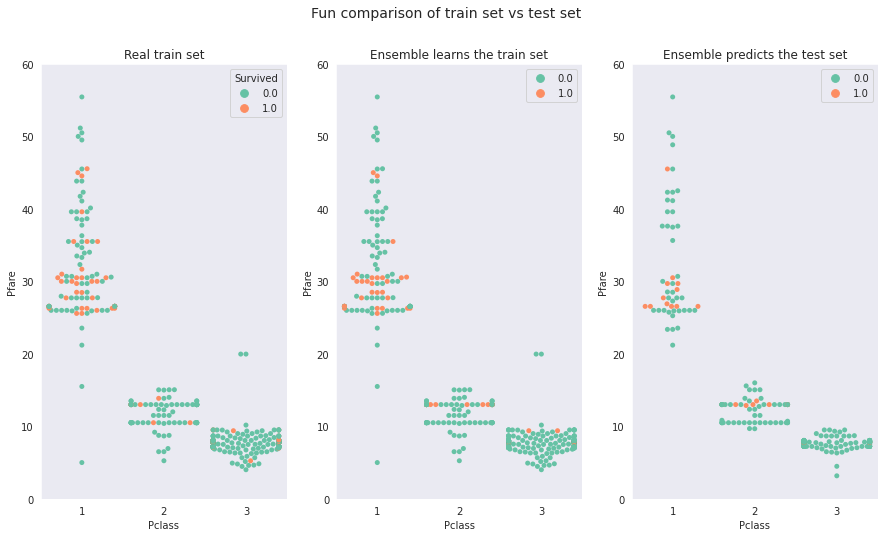

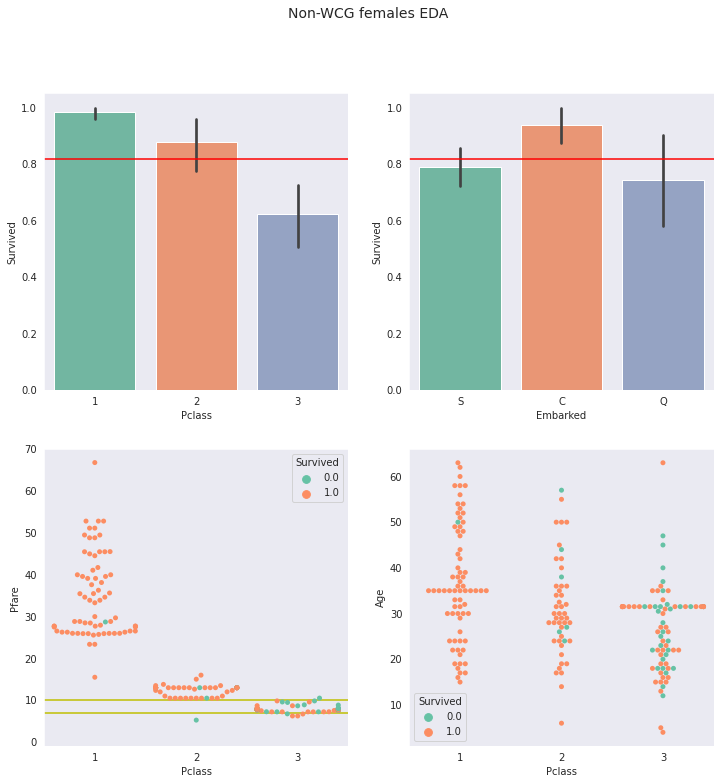

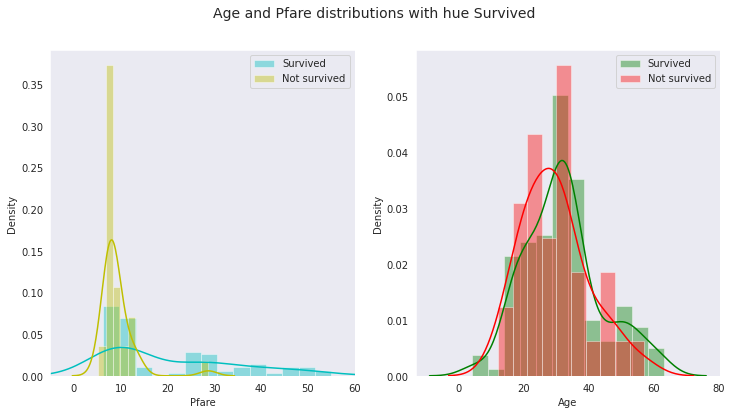

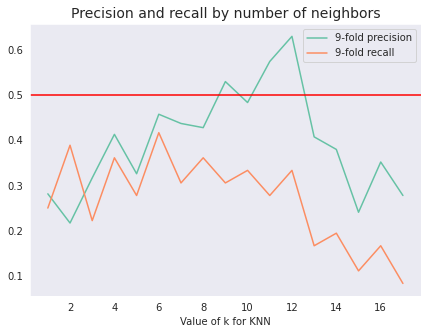

9-fold precision of the ensemble: 0.511
9-fold recall of the ensemble: 0.278
9-fold accuracy of the ensemble: 0.818

The following 6 non-WCG females are predicted to die:


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 50.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 30.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 50.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 52.2% of the points cannot be placed; y

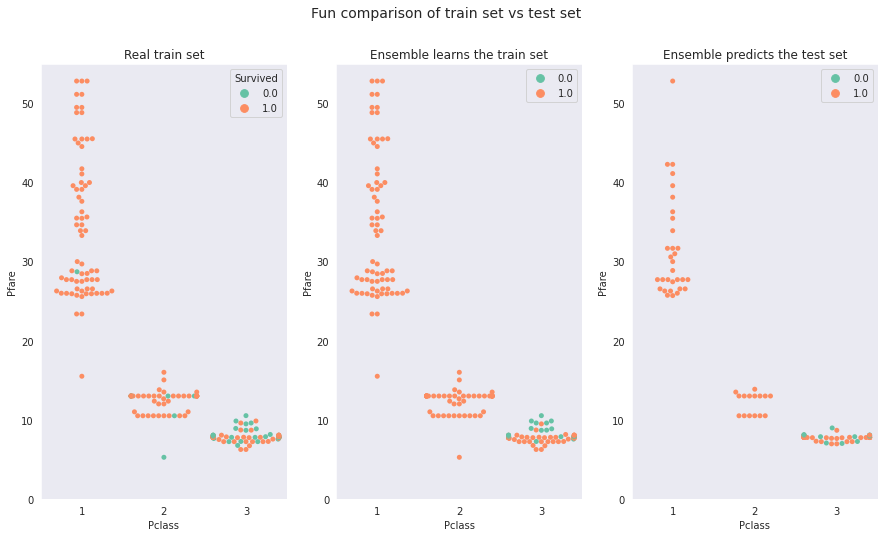

In [ ]:
# -*- coding: utf-8 -*-
"""Jun2_0900AgeCategory_.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/12kqOTUbrbMv6-JKvCokVJowqTpA4DQtY

ChinaとRevを前処理にしても影響ゼロ
Ageを要因に加えてみるテスト

# Scoring over 83%, is it really possible?  
Two years have passed since Chris Deotte pushed the top score of the Titanic competition at 82,8% (note that this score is evaluated with the new 100% public leaderboard, previously it was 85,1%, for more info check the discussion [here](https://www.kaggle.com/c/titanic/discussion/179147)).  
For sure he did a great job and inspired lots of people, but is there a way to improve on his work?  
This notebook finds some adult male survivors with a simple approach, so definitely yes... but can we score over 83%?  
If you are new to the competition, I recommend you to play for a while with it and come back later, otherwise let's get started!
![](attachment:WCG%20pipeline-min.jpg)
"""

# Commented out IPython magic to ensure Python compatibility.
from google.colab import drive
#drive.mount('/content/drive')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
sns.set_style('dark')
sns.set_palette('Set2')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

"""We first load train and test data and join the two dataframes as it will be much easier to perform all our next operations."""

# 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
# データの読み込み方がわからない方は、別途配布している、GoogleColabにおけるドライブのマウントの仕方、と、Google Drive上でのフォルダ構造の説明のpdfファイルをご覧ください。
#train_url = 'https://drive.google.com/uc?id=10CDxSTdXdtwysb3OLRg4Opj4WdKRBcvP'
#test_url = 'https://drive.google.com/uc?id=1hlbby9U7-ZYhGkl9E1jQ4Un1SFpqLJCJ'

df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
#df = pd.read_csv('drive/MyDrive/GCI/train.csv')
#df = pd.read_csv(train_url)
#df_test = pd.read_csv('drive/MyDrive/GCI/test.csv')
#df_test = pd.read_csv(test_url)

# testデータの'Perished'にNaNを埋めてtrainデータと接合する
df_test_column_added = df_test
df_test_column_added['Perished'] = np.NaN

df_combined_original = pd.concat([df,df_test_column_added])

# Ticket_frequency
df_passengerId_ticketFrequency_dict = df_combined_original.groupby('Ticket')['PassengerId'].count().to_dict()
df_passengerId_ticketFrequency_dict
df_combined_original['Ticket_frequency'] = df_combined_original['Ticket'].map(df_passengerId_ticketFrequency_dict)
df_combined_original['Adjusted_Fare'] = df_combined_original['Fare'] / df_combined_original['Ticket_frequency']

# Fareを　Adjusted_Fareに置き換える。
#df_combined_original['Fare'] = df_combined_original['Adjusted_Fare']

# 'Name'columnから姓(surname)と敬称(middle)を抽出
df_combined_name_splited = df_combined_original['Name'].str.split(',', expand=True)
df_combined_surname = df_combined_name_splited[0]
df_combined_middle = df_combined_name_splited[1].str.split('.', expand=True)[0]
df_combined_original['surname'] = df_combined_surname
df_combined_original['middle'] = df_combined_middle.str.strip()
df_combined = df_combined_original

# うち親または子の数がゼロでないレコード
df_with_Parch = df_combined.loc[ df_combined['Parch'] > 0, :]
df_with_Parch['middle'].drop_duplicates()
# うちMrs
df_Mrs = df_with_Parch.loc[df_with_Parch['middle'].str.contains('Mrs'), :]
df_Mrs['Family'] = 'mother'
df_Mrs['Age'].fillna(int(df_Mrs['Age'].mean()), inplace=True)

# うちMaster
df_Master = df_with_Parch.loc[df_with_Parch['middle'].str.contains('Master'), :]
df_Master['Family'] = 'child'
#print(df_Master['Age'].mean())
df_Master['Age'].fillna(int(df_Master['Age'].mean()), inplace=True)

# うちMiss
df_Miss = df_with_Parch.loc[df_with_Parch['middle'].str.contains('Miss'), :]
df_Miss['Family'] = 'child'
#print(max(df_Miss['Age']))
df_Miss['Age'].fillna(int(df_Miss['Age'].mean()), inplace=True)

# うちMr
df_Mr = df_with_Parch.loc[df_with_Parch['middle'].str.endswith('Mr'), :]
df_Mr['Family'] = 'father'
df_Mr['Age'].fillna(int(df_Mr['Age'].mean()), inplace=True)

# うちCapt
df_Capt = df_with_Parch.loc[df_with_Parch['middle'].str.endswith('Capt'), :]
df_Capt['Family'] = 'father'
df_Capt['middle'] = 'Mr'

# うちRev
df_Rev = df_with_Parch.loc[df_with_Parch['middle'].str.endswith('Rev'), :]
df_Rev['Family'] = 'father'

# うちDr
df_Dr = df_with_Parch.loc[df_with_Parch['middle'].str.endswith('Dr'), :]
df_Dr['Family'] = 'father'
df_Dr['middle'] = 'Mr'

df_with_Parch_age_added = pd.concat([df_Mrs, df_Master, df_Miss, df_Mr, df_Capt, df_Rev, df_Dr])

df_without_Parch = df_combined.loc[ df_combined['Parch'] == 0, :]

#うち　SibSp > 0
df_with_SibSp = df_without_Parch.loc[ df_without_Parch['SibSp'] > 0, :]
# うちMrs
df_Mrs_nc = df_with_SibSp.loc[df_with_SibSp['middle'].str.contains('Mrs'), :]
df_Mrs_nc['Family'] = 'wife'
df_Mrs_nc['Age'].fillna(int(df_Mrs_nc['Age'].mean()), inplace=True)
# うちMaster
df_Master_nc = df_with_SibSp.loc[df_with_SibSp['middle'].str.contains('Master'), :]
df_Master_nc['Family'] = 'child'
df_Master_nc['Age'].fillna(int(df_Master_nc['Age'].mean()), inplace=True)

# うちMiss
df_Miss_nc = df_with_SibSp.loc[df_with_SibSp['middle'].str.contains('Miss'), :]
df_Miss_nc['Family'] = 'child'
#print(max(df_Miss['Age']))
df_Miss_nc['Age'].fillna(int(df_Miss_nc['Age'].mean()), inplace=True)

# うちMr
df_Mr_nc = df_with_SibSp.loc[df_with_SibSp['middle'].str.endswith('Mr'), :]
df_Mr_nc['Family'] = 'husband'
df_Mr_nc['Age'].fillna(int(df_Mr_nc['Age'].mean()), inplace=True)

# うちRev
df_Rev_nc = df_with_SibSp.loc[df_with_SibSp['middle'].str.endswith('Rev'), :]
df_Rev_nc['Family'] = 'husband'

# うちDr
df_Dr_nc = df_with_SibSp.loc[df_with_SibSp['middle'].str.endswith('Dr'), :]
df_Dr_nc['Family'] = 'husband'
df_Dr_nc['middle'] = 'Mr'

# うちLady
df_Lady = df_with_SibSp.loc[df_with_SibSp['middle'].str.endswith('Lady'), :]
df_Lady['Family'] = 'child'
df_Lady['middle'] = 'Miss'

# うちSir
df_Sir = df_with_SibSp.loc[df_with_SibSp['middle'].str.endswith('Sir'), :]
df_Sir['Family'] = 'husband'

# うちCol
df_Col = df_with_SibSp.loc[df_with_SibSp['middle'].str.endswith('Col'), :]
df_Col['Family'] = 'husband'
df_Col['middle'] = 'Sir'

df_with_SibSp_age_added = pd.concat([df_Mrs_nc, df_Master_nc, df_Miss_nc, 
                                     df_Mr_nc, df_Rev_nc, df_Dr_nc,
                                     df_Lady, df_Sir, df_Col])

df_without_SibSp =  df_without_Parch.loc[ df_without_Parch['SibSp'] == 0, :]
df_without_SibSp['Family'] = 'without_SibSp'

# Age欠損値の補完

df_without_SibSp['Age'].fillna(df_without_SibSp.mean()['Age'], inplace=True)

# Adjusted_Fare欠損値の補完

df_without_SibSp_Fare_na_Pclass = df_without_SibSp.loc[df_without_SibSp['Adjusted_Fare'].isnull(),'Pclass'].iloc[0]
df_without_SibSp_Fare_na_Embarked = df_without_SibSp.loc[df_without_SibSp['Adjusted_Fare'].isnull(),'Embarked'].iloc[0]
df_same_Pclass = df_combined_original.loc[df_combined_original['Pclass'] == df_without_SibSp_Fare_na_Pclass, :]
df_same_Pclass_Embarked_Fare = df_same_Pclass.loc[df_same_Pclass['Embarked'] == df_without_SibSp_Fare_na_Embarked, 'Adjusted_Fare'].mean()
df_without_SibSp['Adjusted_Fare'].fillna(df_same_Pclass_Embarked_Fare, inplace=True)

df_without_SibSp_age_added = df_without_SibSp

df_age_added = pd.concat([df_with_Parch_age_added,
                          df_with_SibSp_age_added,
                          df_without_SibSp_age_added])

# Embarked欠損値の補完

df_age_added_Embarked_na_ticket = df_age_added.loc[df_age_added['Embarked'].isnull(),'Ticket'].iloc[0]
df_same_ticket = df_age_added.loc[df_age_added['Ticket'].str.startswith(df_age_added_Embarked_na_ticket[0:4]) ,'Embarked'].sort_values().iloc[0]
df_age_added['Embarked'].fillna(df_same_ticket, inplace=True)

# Cabinの頭文字抽出

df_age_added['FCabin']=df_age_added['Cabin'].str[0]
df_age_added['FCabin'].fillna('N', inplace=True)

# 家族の人数
df_age_added['Family_no']=df_age_added['SibSp']+df_age_added['Parch']+1
df_age_added['WithFamily']=np.where(df_age_added['Family_no']>1,1,0)

# age_category

df_age_added['AgeCategory']=np.where((df_age_added['Age']>30)&(df_age_added['Age']<50),1,0)

df = df_age_added.loc[df_age_added['Perished'].notna()]
df_test = df_age_added.loc[ df_age_added['Perished'].isna()].drop(['Perished'], axis=1)

df['Survived'] = 1 - df['Perished']
df_test['Survived'] = 1 - df['Perished']
df.drop('Perished', axis = 1, inplace=True)

train_data = df
test_data = df_test

#train_data = pd.read_csv('../input/titanic/train.csv')
#test_data = pd.read_csv('../input/titanic/test.csv')
data = pd.concat([train_data, test_data]).reset_index().drop(['index'], axis=1)

df.head()

"""# Woman-Child-Groups (WCG)
If we want to get the most accurate Titanic model ever, for sure we have to start with the best component available: let's code the final version of the WCG model developed by Chris in the first part of the [Titanic Mega Model](https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210).  
If you haven't already, check that notebook out because it is really clear and contains one dotplot visualization that explains the idea behind the grouping models.  
Just with the WCG model, we will achieve 81,6% (confirmed to be 83,7% in the old public leaderboard before the change) and we will then work our way to the top.  
The first thing to do is extract the surname from the `Name` column, as it will be essential in engineering a `Group_id` feature that precisely identifies families.  
"""

data['Surname'] = data['Name'].apply(lambda x: x.split(',')[0])

"""For each passenger, let's now concatenate the strings `Surname + Pclass + Ticket + Fare + Embarked` to have an alphanumeric one under the name `Group_id`.  
As proved in [this](https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting) notebook by Erik Bruin, sometimes tickets of passengers traveling together differ in their last digit, so let's also remove the last digit to be consistent and identify the largest number of groups (for example, the `Ticket` value 'CA. 2343' will become 'CA. 234').  
The other features such as `SibSp` and `Parch` are purposely not included in the `Group_id` because they contain errors and are not equal for every family component.  
The `Cabin` column is not included either because too much data is missing.  
Let's write a group_id function that does exactly what we need.  
We pass through a `Ticket_id` helper column that we will reuse later.
"""

# New Ticket_id column
data['Ticket_id'] = 'new_col'
# Initialize Ticket_id = Pclass + Ticket + Fare + Embarked
def ticket_id(row):
    row['Ticket_id'] = str(row.Pclass) + '-' + str(row.Ticket)[:-1] + '-' + str(row.Fare) + '-' + str(row.Embarked)
    return row

data = data.apply(ticket_id, axis='columns')

# New Group_id column
data['Group_id'] = 'new_col2'
# Initialize Group_id = Surname + Ticket_id
def group_id(row):
    row['Group_id'] = str(row.Surname) + '-' + str(row.Ticket_id)
    return row

data = data.apply(group_id, axis='columns')

"""Now we divide the passengers into three categories: men, women and children (only male ones).  
From the latter two, WCG will be created and we will assign a survival rate to the group so we can make predictions for each member in case he/she is in the test data.
"""

# creation of the Title feature
data['Title'] = 'man'
data.loc[data.Sex == 'female', 'Title'] = 'woman'
data.loc[data['Name'].str.contains('Master'), 'Title'] = 'boy'

"""We now assign the label 'noGroup' to every man and count the frequency for each `Group_id` element of the dataframe in the new `WC_count` column.  
We will then assign 'noGroup' also to every woman or child whose `Group_id` value is unique (i.e. with frequency one) in the entire dataframe.
"""

data.loc[data.Title == 'man', 'Group_id'] = 'noGroup'
# New column with WC frequency
data['WC_count'] = data.loc[data.Title != 'man'].groupby('Group_id')['Group_id'].transform('count')
# assign noGroup to every unique value
data.loc[data.WC_count <=1, 'Group_id'] = 'noGroup'

"""Now a great idea, which definitely helps: adding relatives to the groups we identified so far.  
What characteristics do these people share with the other group members?  
Well, they have a different `Surname` but all the other entries are equal, so they have the same `Ticket_id`.  
Let's see an example.
"""

cols = ['PassengerId', 'Survived', 'Name', 'Title', 'Ticket_id','Group_id']
#cols = ['PassengerId', 'Survived', 'Name', 'Title', 'Ticket_id','Group_id',"middle"]
data.loc[(data.Ticket_id == '1-1696-134.5-C') & (data.Title != 'man'), cols]

"""All these people have the same `Pclass`, `Fare`, `Embarked` and `Ticket` number, but two of them are considered part of any group: this is what we are going to fix.  
So let's search for these alone women (or children) which are most likely part of an already existing group.  
We loop through all the passengers whose `Group_id` is 'noGroup' and who are not adult males: if we find that their `Ticket_id` value occurs in an existing group, we change the passenger's `Group_id` entry.
"""

indices = []
count = 0
for i in range(0,1309):
    if (data.loc[i,'Title'] != 'man') & (data.loc[i,'Group_id'] == 'noGroup'):
        data.loc[i,'Group_id'] = data.loc[(data['Ticket_id'] == data.loc[i, 'Ticket_id']) & (data.Title != 'man'), 'Group_id'].iloc[0]
        if (data.loc[i, 'Group_id'] != 'noGroup'):
            indices.append(i)
            count += 1
print('{:d} passengers were added to an existing group'.format(count))

"""And here we are, 11 passengers were added to a group. Let's see them."""

cols = ['PassengerId', 'Survived', 'Name', 'Title', 'Group_id']
data.loc[indices, cols]

"""It looks like 9 of those 11 passengers are in the test data, so there is definitely the possibility to find other females who died, nice!  
Just to understand how many passengers are part of a group, let's make a quick analysis.
"""

number_of_groups = data.loc[data.Group_id != 'noGroup', 'Group_id'].nunique()
print('Number of groups found: {:d}'.format(number_of_groups))
number_of_WCG_passengers = data.loc[data.Group_id != 'noGroup', 'Group_id'].count()
print('\nNumber of passengers in a group: {:d}'.format(number_of_WCG_passengers))
composition = data.loc[data.Group_id != 'noGroup','Title'].value_counts()
print('\nComposition of the groups:')
print(composition.to_string())

"""So we found 80 woman-child-groups, for a total of 230 passengers: 171 women and 59 boys.  
Let's move on to the central aspect of this approach: calculate the average survival rate of each group.  
Here is how it is done: we simply group by `Group_id` and evaluate the mean for the known `Survived` values.
"""

data['WCSurvived'] = data.loc[(data.Title != 'man') & (data.Group_id != 'noGroup')].groupby('Group_id').Survived.transform('mean')

"""Now we have something like this: if a group has both passengers in the train and test data, the second ones have an associated `WCSurvived` value that is the mean of the `Survived` values in the train data for that particular group."""

cols = ['PassengerId', 'Survived', 'WCSurvived', 'Name', 'Title', 'Group_id']
data.loc[data.Group_id == 'Sage-3-CA. 234-69.55-S', cols]

"""We can understand the power of this approach now if we look at all the values that `WCSurvived` assumes."""

print('WCSurvived all data values:')
print(data.WCSurvived.value_counts().to_string())
plt.figure(figsize=(7,5))
f = sns.countplot(y=data.WCSurvived)

"""The unique values count confirms that generally the assumption that these groups lived or perished together is absolutely correct: that is the real power of the WCG model.  
Only 11 people have a non-integer `WCSurvived` value: the Allisons and the Asplunds.  
We see that most of them are in the train data, so for the only three people in the test set we will just use the gender model and hope for the best.  
"""

data.loc[(data.WCSurvived==0.75) | (data.WCSurvived==0.5), cols].sort_values(by='Group_id')

"""We are not done yet as there are some family groups with all members in the test data.  
For this reason, they have an unknown family survival rate, but we will assume that every component of the family underwent the same fate as our WCG hypothesis.
"""

# Get the family names using set difference
test_groups = set(data[891:1309].Group_id.unique()) - set(data[0:891].Group_id.unique())
data.loc[data.Group_id.isin(test_groups), cols].sort_values(by='Group_id')

"""These families are the Gibsons, Klasens, Peacocks, van Billiards.  
We need to make predictions for them so let's explore which woman-child-groups live or die.
"""

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Woman-child-groups analysis', fontsize=14)
a = sns.barplot(x='Pclass', y='Survived', data=data[data.Group_id != 'noGroup'], ax=ax[0]).set_ylabel('Survival rate')
b = sns.barplot(x='Embarked', y='Survived', data=data[data.Group_id != 'noGroup'], ax=ax[1]).set_ylabel('Survival rate')

"""From this analysis, we immediately see that woman-child-groups traveling in `Pclass` 1 or 2 mostly survived and woman-child-groups in `Pclass` 3 mostly perished.  
Since the Gibsons had `Pclass` 1 and `Embarked` C while the Klasens, Peacocks, and van Billiards had `Pclass` 3 and `Embarked` S, our best bet is to assume that the Gibsons survived and the other three families died.
"""

# Assign WCSurvived = 0 to 3rd class test families, else 1
data.loc[data.Group_id.isin(test_groups), 'WCSurvived'] = 0
data.loc[(data.Group_id.isin(test_groups)) & (data.Pclass != 3), 'WCSurvived'] = 1

"""Now, this is the total number of passengers in the test set by `WCSurvived` value: we are finally ready to make predictions."""

print('WCSurvived test values:')
print(data[891:1309].WCSurvived.value_counts().to_string())

"""## Make WCG predictions and submission to Kaggle
There are 74 passengers part of a woman-child-group in the test dataset.  
Let's apply these two prediction rules on top of the gender model which simply predicts that all men (including children) die while all women live: 
* Predict die for all females whose entire family, excluding adult males, all die as indicated by the `WCSurvived` column equaling 0  
* Predict live for all boys whose entire family, excluding adult males, all live as indicated by the `WCSurvived` column equaling 1
"""

# Set everyone to 0
data.loc[891:1308, 'Predict'] = 0
# Set women to 1, completing the gender model
data.loc[891:1308, 'Predict'][(data.Sex == 'female')] = 1
# Change WCG women with WCSurvived=0 to 0
data.loc[891:1308,'Predict'][(data.Sex == 'female') & (data['WCSurvived'] == 0)] = 0
# Change WCG boys with WCSurvived=1 to 1, completing the WCG + gender model
data.loc[891:1308, 'Predict'][(data.Title == 'boy') & (data['WCSurvived'] == 1)] = 1
# With this, the three group members with non-integer WCSurvived are not changed from the gender model

# Class3の6人グループの中国人を生存に変更
data.loc[891:1308, 'Predict'][(data.Ticket_frequency == 6) & (data['Pclass'] == 3)] = 1

"""Here is a summary of which passengers are predicted to live or die from the previous prediction rules."""

print('The following 8 males are predicted to live:')
cols = ['PassengerId', 'Name', 'Title', 'Group_id']
data[891:1309][cols].loc[(data.Title == 'boy') & (data.Predict == 1)]

print('The following 15 females are predicted to die:')
data[891:1309][cols].loc[(data.Title == 'woman') & (data.Predict == 0)]

print('The remaining 258 males are predicted to die')
print('and the remaining 137 females are predicted to live')

"""Now we submit the predictions to the leaderboard: at the time I first tried doing this, the old leaderboard with only 50% of test data was still in use.  
However, now that I am publishing the notebook, there is the new one that uses all of the test data to calculate the score and it appears that they are lower as much as 2% (reason explained [here](https://www.kaggle.com/c/titanic/discussion/179147)).
"""

output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
#output.to_csv('WCG_gender.csv', index=False)
#print('WCG_gender submission was successfully saved!')
#print('Submission is loading... you scored 81,6%!')

"""Nice, as good as we expected!  
This extremely simple woman-child-group model scores 81,6% in the new and current leaderboard (341 correct predictions) which is really impressive.  
Considering that the gender submission scores 76,5% (which is 320 correct predictions) and this model changes 23 of them, it means 22/23 are correct!  
With the old leaderboard, I confirm that it was 83,7% so definitely not bad.
# Non-WCG passengers
For the second part of this notebook, we will focus on non-WCG passengers, who are adult males on one side and females who are not part of an existing group on the other.  
## Fixing the Fare column
Before starting we will do a couple of things.  
First of all, we fix rows with a `Fare` amount of 0 assigning them a null value that will be imputed later when we come to modeling.  
As pointed out by Erik Bruin [here](https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting), the information might be correct (a quick research showed for example that some of them were part of the guarantee group), but the zero-fares might confuse the algorithms as most of them are within the 1st and 2nd class passengers.  
In this notebook, I actually ended up using KNNs so this preprocessing makes no difference, but if I wanted to use something else this may help and that's why I leave it.
"""

# Assign np.NaN to zero-fares
def fix_fare(row):
    if row.Fare == 0:
        row.Fare = np.NaN
    return row
print('The following {:d} passengers have a zero Fare:'.format(data[data.Fare==0].shape[0]))
cols = ['PassengerId', 'Survived', 'Pclass','Fare', 'Name']
data.loc[data.Fare==0, cols]

"""Here you can see the difference before and after removing zero fares.  """

fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle('Removing zero fares: before and after', fontsize=14)
a = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[0])
ax[0].axhline(y=2, color='r')
# Apply the fix_fare function 
data = data.apply(fix_fare, axis='columns')
ax[1].axhline(y=2, color='r')
b = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[1])

"""Next, we modify the `Fare` column another time to create the `Pfare` feature that is just a passenger's `Fare` divided by his ticket frequency.  
This mostly helps in reducing the range of the `Fare` feature and also fixes some outliers.  
Again, here you find the difference before and after: note the scale difference on the y-axis.
"""

# Calculate Ticket frequency and divide Fare by it
data['Ticket_freq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['Pfare'] = data['Fare'] / data['Ticket_freq']

fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle('Fare and Pfare compared', fontsize=14)
a = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[0])
b = sns.swarmplot(x='Pclass', y='Pfare', data=data, ax=ax[1])

"""As you can see, the range is reduced from over 500 to 125, the second class is now more compact and the third class lost most of its outliers with really high fares.  
With these two small tweaks, we are now ready to go.
## Explore adult males
Adult males are the most difficult category to make predictions for.  
Most of the models we see here on Kaggle predict that all of them die and if not, usually the results are not satisfactory.  
Here my idea seems to work, even if not with magnificent results: let's dive into it.
"""

# 8人グループの中国人は生存
data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Ticket_frequency==8))] = 1
data.loc[0:1308, 'WCSurvived'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Ticket_frequency==8))] = 1

# TitleがRevの人は死亡
data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.middle=='Rev'))] = 0
data.loc[0:1308, 'WCSurvived'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.middle=='Rev'))] = 1

# Isolating adult males in train and test set
train_male = data[0:891].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]
test_male = data[891:1309].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]

"""Now let's perform a short analysis to see what features might be useful considering.  
In red I plotted the average survival rate for adult males in the train data.
"""

fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Adult males EDA', fontsize=14)
sns.barplot(x='Pclass', y='Survived', data=train_male, ax=ax[0][0])
ax[0][0].axhline(y=train_male.Survived.mean(), color='r')
sns.barplot(x='Embarked', y='Survived', data=train_male, ax=ax[0][1])
ax[0][1].axhline(y=train_male.Survived.mean(), color='r')
sns.swarmplot(x='Pclass', y='Pfare', hue='Survived', data=train_male, ax=ax[1][0])
ax[1][0].axhline(y=25, color='y')
ax[1][0].axhline(y=32, color='y')
a = sns.swarmplot(y='Age', x='Pclass', hue='Survived', data=train_male, ax=ax[1][1])

"""We draw some interesting conclusions: `Pclass` is definitely useful and also `Embarked`, even though these two features are not independent (see why if you didn't know this).  
What about `Pfare`? We see there is a nice concentration of orange dots in the first class with `Pfare` between 25 and 32 (almost 50%), so this may be our best chance to guess some male survivors.  
What about `Age` instead? We recognize that the value of `Pclass` is the most discriminative because `Age` alone is very confusing (try tracing two horizontal lines as we did for `Pfare`).  
Let's see the distributions of the two numerical features to understand their influence on the target variable.
"""

x1 = train_male.loc[train_male['Survived']==1, 'Pfare']
x0 = train_male.loc[train_male['Survived']==0, 'Pfare']
y1 = train_male.loc[train_male['Survived']==1, 'Age']
y0 = train_male.loc[train_male['Survived']==0, 'Age']

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Age and Pfare distributions with hue Survived', fontsize=14)
sns.distplot(x1, bins=30, label = 'Survived', ax = ax[0], color = 'c')
sns.distplot(x0, bins=25, label = 'Not survived', ax = ax[0], color = 'y')
ax[0].set_xlim(-5, 70)
ax[0].legend()
sns.distplot(y1, bins=20, label = 'Survived', ax = ax[1], color = 'g')
sns.distplot(y0, bins=20, label = 'Not survived', ax = ax[1], color = 'r')
ax[1].legend()
fig.show()

"""We notice the `Age` distributions mostly overlap, while the `Pfare` ones do not (note the different height).  
So, is it leaving out `Age` the correct choice? I think yes.
## Let's build an ensemble
What information can we extract from the `Pfare`, `Pclass`, `Embarked` columns?  
Are they enough to detect some male survivors?  
Let's build an ensemble of three models and we will see!  
I used only K-Nearest Neighbors just to have fun: it may not be the best choice (and I am pretty sure about that) but I encourage you to fork this notebook and try your models.  
Since the classes are very imbalanced (the deads are more than 5 times the survivors), accuracy might not be a good metric here: for example, cross-validation accuracy for the predict all die model is 0.84!  
We are interested in precision and recall instead, i.e. respectively how many of the samples predicted as survivors actually lived and how many survivors are captured by our positive predictions.
![](attachment:precision-recall-min.jpg)
*Image by Walber - Own work, CC BY-SA 4.0, [link](https://commons.wikimedia.org/w/index.php?curid=36926283).*  

Since the survivors are very spread out, we don't expect our model to have a high recall but we would like to have a decent precision for sure.  
Note that with respect to these two metrics, the predict all die model has a score of 0.0 and 0.0!  
Let's see how these two metrics vary in a KNN model when we change the number of neighbors.
"""



cols = ['PassengerId', 'Name', 'Pfare', 'Pclass', 'Embarked']
y_m = train_male['Survived']
features = ['Pfare', 'Pclass', 'Embarked', 'WithFamily', 'AgeCategory']

X_m = train_male[features]

numerical_cols = ['Pfare']
categorical_cols = ['Pclass', 'Embarked', 'WithFamily', 'AgeCategory']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

precision_m = []
recall_m = []

for k in range(1,18):
    pipeline1 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    precision_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean())
    recall_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean())
    
k_range = range(1,18)
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_m, label='15-fold precision')
plt.plot(k_range, recall_m, label='15-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

"""We see that an even or odd number of neighbors makes a significant difference in the recall score, while the precision has a nice trend almost independent from the parity.  
It is interesting to see that even when the recall is approximately zero, the models maintain a non-zero precision (even though they are pretty useless).  
Let's select our three values for k in the ensemble to be 1, 3 and 7.  
The reason is that the first two are supposed to detect most of the male survivors with a decent recall while the latter is a pretty good model on his own that will improve the total precision.  
I know this is a completely naive approach to an ensemble but forgive me for this!
"""

m1 = KNeighborsClassifier(n_neighbors=1)
m2 = KNeighborsClassifier(n_neighbors=3)
m3 = KNeighborsClassifier(n_neighbors=7)
# Preprocessing is the same as before
male_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting',VotingClassifier([
        ('m1', m1), ('m2', m2), ('m3', m3)]))
])
print('15-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean()))
print('15-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean()))
print('15-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1).mean()))
# Fit model and make predictions
male_pipeline.fit(X_m, y_m)
learn_train_m = male_pipeline.predict(X_m)

X_test_m = test_male[features]
predictions_m = male_pipeline.predict(X_test_m)
print('\nThe following 9 adult males are predicted to live:')
test_male.loc[(predictions_m==1), cols]

"""The 15-fold precision of the ensemble is 0.562, slightly better than 0.5 and in between the original precisions of the three models.  
I know finding some male survivors is a difficult task, so obtaining this >0.5 accuracy is a good result for me.  
Unfortunately, the 15-fold recall of the ensemble is only 0.318 but at least it did not go down from the original recalls of the three models.  
That is a consequence of the sparsity of the survivors, especially in the second and third classes where our model was not able to extract useful patterns (except one, Mr. Ling Hee in the third class!).  
Since we made 9 predictions, there is a concrete possibility that we find some male survivors this time!  
Just for fun, here I compare the train set, how the ensemble learns it and its predictions for the test data.
"""

fig, ax = plt.subplots(1,3,figsize=(15,8))
fig.suptitle('Fun comparison of train set vs test set', fontsize=14)
ax[0].set_title('Real train set')
ax[0].set_ylim(top=60)
sns.swarmplot(x=X_m.Pclass, y=X_m.Pfare, hue=y_m, ax=ax[0])
ax[1].set_title('Ensemble learns the train set')
ax[1].set_ylim(top=60)
sns.swarmplot(x=X_m.Pclass, y=X_m.Pfare, hue=learn_train_m,  ax=ax[1])
ax[2].set_title('Ensemble predicts the test set')
ax[2].set_ylim(top=60)
a = sns.swarmplot(x=test_male.Pclass, y=test_male.Pfare, hue=predictions_m,  ax=ax[2])

"""## Submission to Kaggle
Let's change the adult male predictions of the ensemble from the gender model and submit.  
An advantage of the new 100% public leaderboard is that we have now the possibility to count exactly how many correct predictions we make.
"""

data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull())] = predictions_m

# 5人グループ以上の人は死亡
data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Ticket_frequency>4))] = 0
data.loc[0:1308, 'WCSurvived'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Ticket_frequency>4))] = 1

# 2,3Classで2人以上のグループは死亡　若干の例外
#data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Pclass!=1) & (data.Ticket_frequency>1))] = 0
#data.loc[0:1308, 'WCSurvived'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Pclass!=1) & (data.Ticket_frequency>1))] = 1

# SibSp3人以上の人は死亡
data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.SibSp>2))] = 0
data.loc[0:1308, 'WCSurvived'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.SibSp>2))] = 1

# 2,3ClassでParch1人以上の人は死亡
data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Pclass!=1) & (data.Parch>0))] = 0
data.loc[0:1308, 'WCSurvived'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Pclass!=1) & (data.Parch>0))] = 1

# Class3でage>32は死亡(例外は3ケース)
#data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Pclass==3) & (data.Age>32))] = 0
#data.loc[0:1308, 'WCSurvived'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Pclass==3) & (data.Age>32))] = 1

# Class2でage>43は死亡(例外は１ケース)
data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Pclass==2) & (data.Age>43))] = 0
data.loc[0:1308, 'WCSurvived'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Pclass==2) & (data.Age>43))] = 1

# Class2でage<31は死亡(例外は１ケース)
#data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Pclass==2) & (data.Age<31))] = 0
#data.loc[0:1308, 'WCSurvived'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Pclass==2) & (data.Age<31))] = 1

# Class1でage>60は死亡(例外は１ケース)
#data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Pclass==1) & (data.Age>60))] = 0
#data.loc[0:1308, 'WCSurvived'][(data.Sex=='male') & (data.WCSurvived.isnull() & (data.Pclass==1) & (data.Age>60))] = 1


data.loc[0:1308, 'x2'] = data.loc[0:1308, 'SibSp'] + data.loc[0:1308, 'Parch'] + 1 + data.loc[0:1308, 'Age']/70

train_male = data[0:891].loc[(data.Sex=='male')  & (data.WCSurvived.isnull())]
test_male = data[891:1309].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]

output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
#output.to_csv('WCG_male.csv', index=False)
#print('WCG_male submission was successfully saved!')
#print('Submission is loading... you scored 82,3%!')

"""Wow, we scored 82,3% which is 344 passengers, 3 more correct predictions than the WCG + gender model!  
It means 6 out of our 9 male predictions were correct: we finally found a way to guess some male survivors, yeah!
## Explore non-WCG females
Non-WCG females are a very wide group which contains solo females but also women traveling with their spouse.  
A way to isolate them from the dataframe is of course select null `WCSurvived` entries from the female subpopulation.
"""

train_female = data[0:891].loc[(data.Sex=='female')  & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]

"""As we did before, let's run a quick analysis to see if we can use more features or if `Age` is again not useful."""

fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Non-WCG females EDA', fontsize=14)
sns.barplot(x='Pclass', y='Survived', data=train_female, ax=ax[0][0])
ax[0][0].axhline(y=train_female.Survived.mean(), color='r')
sns.barplot(x='Embarked', y='Survived', data=train_female, ax=ax[0][1])
ax[0][1].axhline(y=train_female.Survived.mean(), color='r')
sns.swarmplot(x='Pclass', y='Pfare', hue='Survived', data=train_female, ax=ax[1][0])
ax[1][0].set_ylim(top=70)
ax[1][0].axhline(y=7, color='y')
ax[1][0].axhline(y=10, color='y')
a = sns.swarmplot(y='Age', x='Pclass', hue='Survived', data=train_female, ax=ax[1][1])

"""For non-WCG females, we definitely see that `Pclass` will be determinant another time and that we have to focus on third-class because the survival rates elsewhere are really high.  
We see there is a decent concentration of green dots in the third class with `Pfare` between 7 and 10, so this may be our best chance to guess some females who died.  
Let's see `Age` and `Pfare` distributions to understand their importance.
"""

w1 = train_female.loc[train_female['Survived']==1, 'Pfare']
w0 = train_female.loc[train_female['Survived']==0, 'Pfare']
z1 = train_female.loc[train_female['Survived']==1, 'Age']
z0 = train_female.loc[train_female['Survived']==0, 'Age']

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Age and Pfare distributions with hue Survived', fontsize=14)
sns.distplot(w1, bins=35, label = 'Survived', ax = ax[0], color = 'c')
sns.distplot(w0, bins=15, label = 'Not survived', ax = ax[0], color = 'y')
ax[0].set_xlim(-5, 60)
ax[0].legend()
sns.distplot(z1, bins=12, label = 'Survived', ax = ax[1], color = 'g')
sns.distplot(z0, bins=10, label = 'Not survived', ax = ax[1], color = 'r')
ax[1].legend()
fig.show()

"""We notice `Age` is again not really astonishing while `Pfare` is the one which will help us the most.  
Let's try not to use `Age` and hope for the best: we already found some male survivors so we are more than happy with the result.
## Let's build an ensemble, again
We will make our predictions through an ensemble of three models, using KNNs just for fun.  
I encourage you to fork this notebook and try your models if you don't like this choice!  
Since the classes are very imbalanced another time (the survivors are 4.5 times the deads), accuracy is not a good metric here: for example, cross-validation accuracy for the predict all live model is 0.818!  
Since sklearn metrics use 1 as the default value for positive samples, we have to create our custom metrics that use 0 as the positive value.
"""



from sklearn.metrics import make_scorer, precision_score, recall_score
# We set zero_division=0 to avoid raising errors
custom_precision = make_scorer(precision_score, pos_label=0, zero_division=0)
custom_recall = make_scorer(recall_score, pos_label=0)

"""Again, we don't expect our model to have a high recall but we would like to have a decent precision.  
Note that with respect to these two custom metrics, the predict all live model has a score of 0.0 and 0.0!  
Let's vary the number of neighbors in a KNN model and see how these two quantities change.
"""

y_f = train_female['Survived']
X_f = train_female[features]
precision_f = []
recall_f = []
# Preprocessing is always the same...
for k in range(1,18):
    pipeline2 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    # We use 9-fold because the train size is smaller
    # and 198/9 = integer
    precision_f.append(cross_val_score(pipeline2, X_f, y_f, cv=9, n_jobs=-1, scoring=custom_precision).mean())
    recall_f.append(cross_val_score(pipeline2, X_f, y_f, cv=9, n_jobs=-1, scoring=custom_recall).mean())
    
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_f, label='9-fold precision')
plt.plot(k_range, recall_f, label='9-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

"""Oh, what a strange plot!  
We see the effect of parity is huge, that it takes a while to increase accuracy over 0.5 and that we have to lose almost half of the recall to gain that.  
This time, precision and recall also go to zero at the same time which is a cool thing.  
I'll try to select the KNN models with k values of 4, 9, 11 with a similar logic as before: we take the high recall of the first, we combine it to the high precision of the second and we add the third that has a little bit of both.  
Let's see how it goes...
"""

f1 = KNeighborsClassifier(n_neighbors=4)
f2 = KNeighborsClassifier(n_neighbors=9)
f3 = KNeighborsClassifier(n_neighbors=11)
# Preprocessing pipelines are the same as before
female_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting', VotingClassifier([
        ('f1', f1), ('f2', f2), ('f3', f3)]))
])
print('9-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9, scoring=custom_precision).mean()))
print('9-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9, scoring=custom_recall).mean()))
print('9-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=9).mean()))
# Preprocessing of training data, fit model
female_pipeline.fit(X_f, y_f)
learn_train_f = female_pipeline.predict(X_f)
X_test_f = test_female[features]
predictions_f = female_pipeline.predict(X_test_f)
print('\nThe following 6 non-WCG females are predicted to die:')
test_female.loc[(predictions_f==0), cols]

"""Wow, the 9-fold precision for the ensemble is 0.571, at least it did not go down!  
The recall isn't great but it's ok, also this one is a difficult task and we don't expect a lot more than this.      
I'm surprised that we made only 6 predictions, but it is what it is with such a small test set (only 97 rows).  
As I did before, here I compare the train set, how the ensemble learns it and its predictions for the test data.  
Thanks to this plot, we can also see that non-WCG females in the third class are not distributed as in the train data and this may explain why we made only a few predictions.  
"""

fig, ax = plt.subplots(1,3,figsize=(15,8))
fig.suptitle('Fun comparison of train set vs test set', fontsize=14)
ax[0].set_title('Real train set')
ax[0].set_ylim(top=55)
sns.swarmplot(x=X_f.Pclass, y=X_f.Pfare, hue=y_f, ax=ax[0])
ax[1].set_title('Ensemble learns the train set')
ax[1].set_ylim(top=55)
sns.swarmplot(x=X_f.Pclass, y=X_f.Pfare, hue=learn_train_f,  ax=ax[1])
ax[2].set_title('Ensemble predicts the test set')
ax[2].set_ylim(top=55)
a = sns.swarmplot(x=test_female.Pclass, y=test_female.Pfare, hue=predictions_f,  ax=ax[2])

data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = predictions_f

# class 1 は全員生存にする
data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull() & (data.Pclass==1))] = 1
data.loc[0:1308, 'WCSurvived'][(data.Sex=='female') & (data.WCSurvived.isnull() & (data.Pclass==1))] = 1
# class 2,3 のうち　SibSpが2以上は全員生存にする 影響なし
#data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull() & (data.SibSp>=2))] = 1
#data.loc[0:1308, 'WCSurvived'][(data.Sex=='female') & (data.WCSurvived.isnull() & (data.SibSp>=2))] = 1
# Cabinが空白でないものは全員生存にする
data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull() & (data.Cabin.notnull()))] = 1
data.loc[0:1308, 'WCSurvived'][(data.Sex=='female') & (data.WCSurvived.isnull() & (data.Cabin.notnull()))] = 1

train_female = data[0:891].loc[(data.Sex=='female')  & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]

"""It's actually pretty funny to see how the ensemble learns the train set but hey, if it works I keep it!
## Final Submission
Now it's time to see if we have a good model that predicts which females die.  
Hopefully, we have the same increment as before and have the best Titanic model ever!  
Let's change these female predictions from the previous model and submit to Kaggle.
"""

output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
#output.to_csv('WCG_male_female.csv', index=False)

# Google Drive・Google Colaboratoryで作業する場合
output.sort_values(by = 'PassengerId', inplace=True)
output['Perished'] = 1 - output['Survived']
output.drop('Survived', axis = 1, inplace=True)
output.to_csv('submission.csv',index=False, encoding = 'utf-8')

#from google.colab import files
#files.download('submission.csv')

"""Wow! Our score increased again and it is now 82,8% which is 346 passengers, 2 more correct predictions than the WCG + adult males model!  
Unfortunately, this is exactly the top score previously available so we were not able to make a breakthrough over 83%... or did we?  
Well, we found some male survivors, that's a great win for me because this is something no one has ever succeeded doing and also indirectly is pushing the top score over its limit.      
If I had ensembled different models for non-WCG females (maybe including `Age` too), I could have probably scored over 83% but that's just an idea I leave here for the readers!  
# Conclusion
First of all, I would like to thank [Chris](https://www.kaggle.com/cdeotte) for his amazing Titanic tutorials as well as [Erik](https://www.kaggle.com/erikbruin) for his careful family analysis and `Fare` tricks which helped a bit.      
Secondly, thank you for reading my notebook!  
I hope you liked it: this was my attempt to push the top score higher and even if I did not succeed, it was still a nice journey.  
I had to look at the problem from another perspective and not using the `Age` column ended up being a way to find some male survivors, so at least I made an important contribution.  
This notebook proves another time that the two tasks of predicting adult male survivors and females not in a group who died are very different and it is really difficult to do both well with the same approach.  
I believe it is possible to increase the public score again ensembling this model with others, mostly to correct some of the female predictions: I think the maximum score achievable could be around 350 passengers, which is 83,7%.  
That being said, I finish this notebook with a short summary of what we did.
# Summary of what we did
This notebook proved that male survivors can be found with simple elements and thus the old top scores have the potential to be improved, especially if we use the WCG model as a strong baseline.  
Here's the pipeline we followed to reach top 1% in the competition and an histogram of Titanic LB scores in September 2020.
![](attachment:Titanic_LB.png)
First, the passengers (train + test) were divided into four groups:
1. Adult males - 60% of the population (A)
1. Young boys (with Master title) - 5% of the population (B)
1. Females that have children, sisters, or mothers (brothers and husbands are optional) - 13% of the population (C)
1. Females that have brothers, or husbands (no children, no sisters, no mothers) or are traveling alone - 22% of the population (D)

Next, we built 3 classifiers:
1. **WCG** on top of the **gender model** to classify (B) + (C)
1. **Ensemble_1** of KNNs to classify (A)
1. **Ensemble_2** of KNNs to classify (D)

Finally we assembled the models. Here are the public scores:
1. **WCG + gender model** scores 81,6% which is 341 correct predictions
1. **WCG + ensemble_1 + all females live** scores 82,3% which is 344 correct predictions
1. **WCG + ensemble_1 + ensemble_2** scores 82,8% which is 346 correct predictions

See you soon in the next one and good luck passing 83%!  
Please let me know down in the comments your suggestions or if you find errors in the code!
"""

data.to_csv('data.csv',index=False, encoding = 'utf-8')


# professional 3手法のデータをダウンロードした積りがアンサンブルの結果3つになっていました。

(891, 12)
訓練データのデータ数は891、変数は12種類です。
テストデータのデータ数は418、変数は11種類です


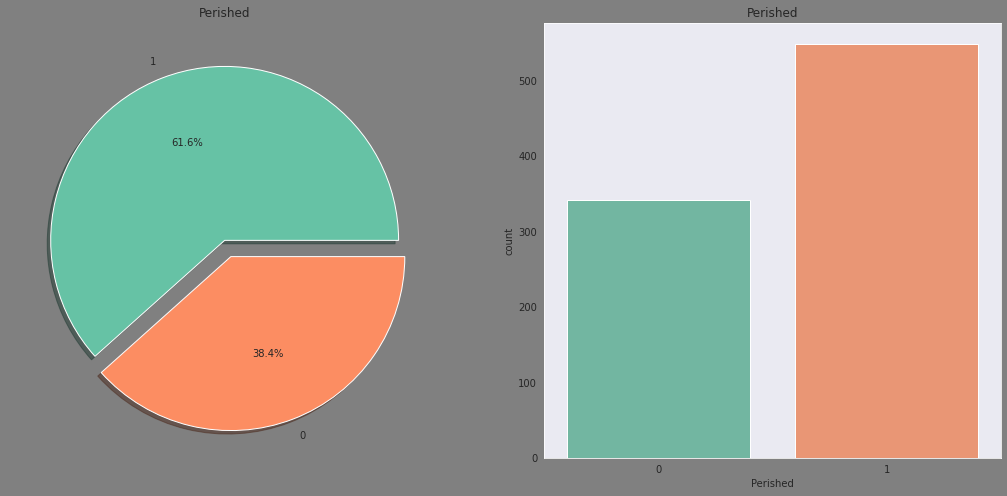

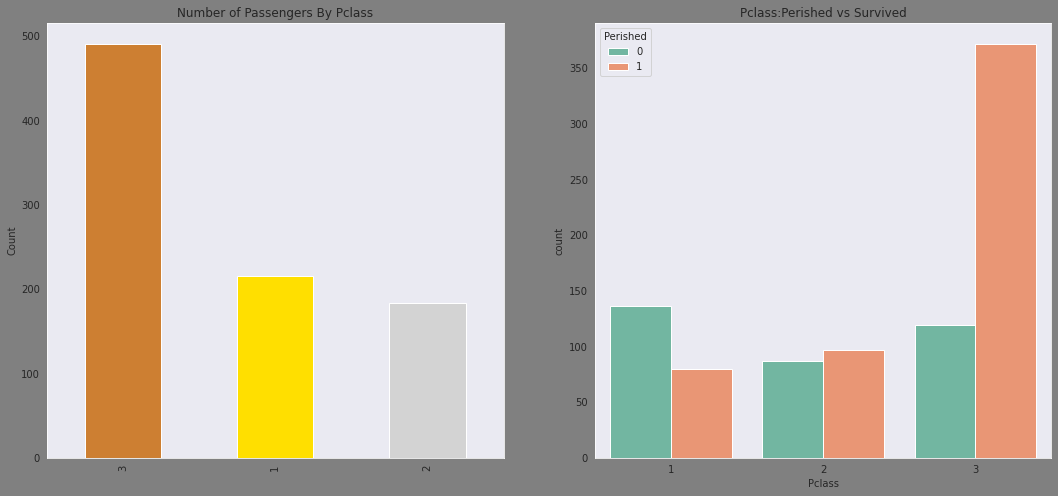

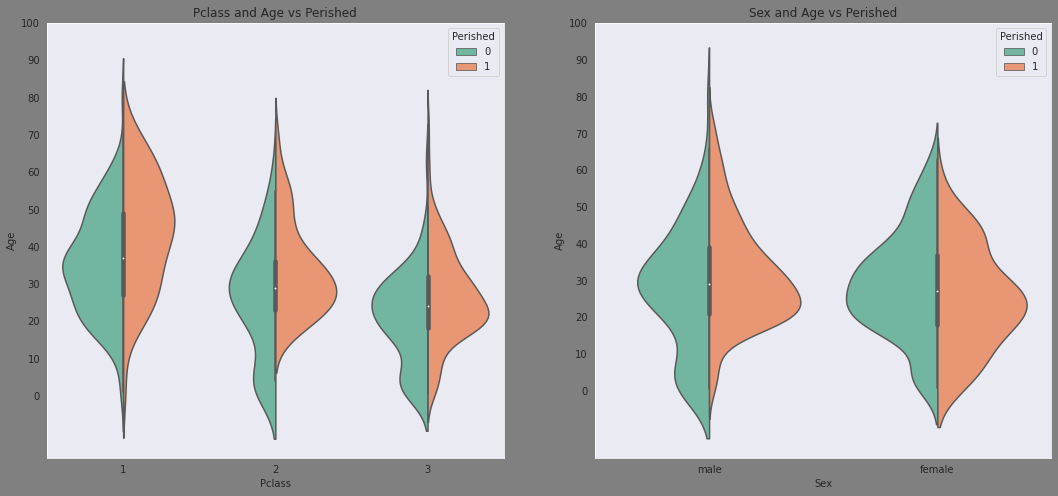

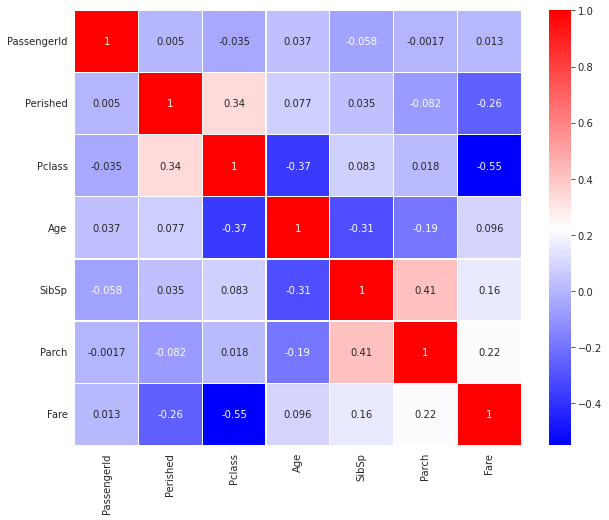

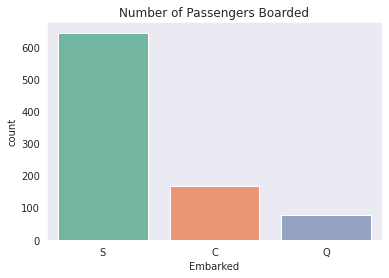

Train Score: 0.953
 Test Score: 0.791
max_depth: 3, min_samples_leaf: 1
    Train Score: 0.844, Test Score: 0.821
max_depth: 3, min_samples_leaf: 2
    Train Score: 0.844, Test Score: 0.821
max_depth: 3, min_samples_leaf: 4
    Train Score: 0.844, Test Score: 0.817
max_depth: 5, min_samples_leaf: 1
    Train Score: 0.88, Test Score: 0.821
max_depth: 5, min_samples_leaf: 2
    Train Score: 0.867, Test Score: 0.806
max_depth: 5, min_samples_leaf: 4
    Train Score: 0.864, Test Score: 0.802
max_depth: 7, min_samples_leaf: 1
    Train Score: 0.899, Test Score: 0.81
max_depth: 7, min_samples_leaf: 2
    Train Score: 0.889, Test Score: 0.787
max_depth: 7, min_samples_leaf: 4
    Train Score: 0.876, Test Score: 0.791
Best Parameters: {'max_depth': 7, 'min_samples_leaf': 2}
CV Score: 0.824
Train Score: 0.905
 Test Score: 0.802
Logistic Regression 

Train Score: 0.799
 Test Score: 0.81
Multilayer Perceptron 

Train Score: 0.823
 Test Score: 0.799


'\u3000この提出ファイルをOmnicampus上で提出してみましょう。本デモンストレーションはこれにて以上です。入門者の方もこのデモンストレーションをベースとするなどし、自分の工夫を一つでも多く加えてみて、スコアと順位の向上を目指してみてください。'

In [ ]:
# -*- coding: utf-8 -*-
"""June04_1600_professional.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/16WGA4GC98GxB1rYpF7Z8tnx5n2GKQ0rL

# Titanic
![](https://i.imgur.com/rRFchA8.png)

## 目次
0. ライブラリ・データ読み込み
1. データの概観・分析・前処理
2. ベースラインモデルの構築
3. 特徴量エンジニアリング
4. 様々なモデルの構築・調整
5. モデルのアンサンブリング
6. 予測の出力・提出

　機械学習を用いたデータ分析では多くの場合、上の目次に示すような工程で問題に取り組みます。ただしこの順番に沿って一方向的に進んでいくのではなく、前後の工程を行ったり来たりしながら作業は進んでいきます。このような工程に関しては、Mark Peng氏による"General Tips for participating Kaggle Competitions"という講演資料で示されたフローチャート（下図）がわかりやすいです。またKaggleそのものについての解説は、Sergey Yurgenson氏による"Kaggle and Data Science"がわかりやすいでしょう。

"General Tips for participating Kaggle Competitions" : https://www.slideshare.net/markpeng/general-tips-for-participating-kaggle-competitions

"Kaggle and Data Science" : https://www.slideshare.net/hijiki_s/kaggle-and-data-science

![](https://image.slidesharecdn.com/kagglesharingmarkpeng20151216finalpresented-151216161621/95/general-tips-for-participating-kaggle-competitions-6-638.jpg?cb=1452565877)

## 0. ライブラリ・データ読み込み  
　まず初めに使用するライブラリを読み込みます。
"""

# このセルを実行したあとどうすればいいかがわからない方は、別途配布している、「GoogleColabにおけるドライブのマウントの仕方」と、Google Drive上でのフォルダ構造の説明のpdfファイルをご覧ください。

from google.colab import drive
#drive.mount('/content/drive')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

"""　次にpandasのread_csv関数を用いて、分析する訓練データ**train.csv**とテストデータ**test.csv**を読み込みます。  
　変数名に与えた**df**は、**DataFrame**を意味しています（変数名は何でも構いません）。テストデータは素直にdf_testと命名したのに対して訓練データはdfとだけ命名したのは、後に説明するホールドアウト法やクロスバリデーションにおいて、さらにdfを擬似的な訓練データdf_trainと擬似的なテストデータdf_validに分割することを見越してのものです。\
※ファイルの読み込み方法は自身の作業場所によって変わります。このnotebookをコピーして用いる場合はそのまま実行することができますが、自分の環境に合わせて適切な形に修正する必要が生じる場合もあります。
"""

#train_url = 'https://drive.google.com/uc?id=10CDxSTdXdtwysb3OLRg4Opj4WdKRBcvP'
#test_url = 'https://drive.google.com/uc?id=1hlbby9U7-ZYhGkl9E1jQ4Un1SFpqLJCJ'
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(df.shape)

"""## 1. データの概観・分析・前処理
### 1.1 データの概観
　データを見ていく上で、まず初めにデータのサイズを確認してみましょう。
"""

print('訓練データのデータ数は{}、変数は{}種類です。'.format(df.shape[0], df.shape[1]))
print('テストデータのデータ数は{}、変数は{}種類です'.format(df_test.shape[0], df_test.shape[1]))

"""　訓練データの初めの10データを見てみましょう。"""

df.head(10)

"""　変数名の一覧を見てみましょう。"""

df.columns

"""これらの変数名を、README.ipynbに示された変数の説明と対応付けておきましょう。  

変数 |定義 |備考  
---|---|---
Perished |死亡したかどうか |0 = No, 1 = Yes
Pclass |チケットのクラス |1 = 1st, 2 = 2nd, 3 = 3rd
Name |名前 |
Sex |性別 |
Age	|年齢 |
SibSp |乗船していた兄弟姉妹・配偶者の数	|
Parch |乗船していた親・子供の数	|
Ticket |チケット番号	|
Fare |チケット料金	|
Cabin |キャビン番号	|
embarked |乗船した港	|C = Cherbourg, Q = Queenstown, S = Southampton

### 1.2 データの分析
　次に**EDA**と呼ばれる作業を行います。EDAとは、**Exploratory Data Analysis**の略で、日本語では**探索的データ分析**と訳されます。EDAでは、データを様々な角度から可視化したり、統計量を見ることで、データの特徴や構造を掴もうと試みます。この工程で得られた知見は機械学習モデルを選ぶ上でも、後に述べる特徴量エンジニアリングにおいても有用です。EDAで得た知見が役立つ理由の一つは、機械学習モデルによって仮定しているデータの特徴が異なることです。EDAによりデータに線型性・独立性・連続性などの特徴が観察できたり、後述の特徴量エンジニアリングでデータを加工することにより顕著な特徴を有した新しいデータを得ることができれば、それに適した機械学習モデルを用いることができます。  
　以下に行うEDAは、"EDA To Prediction (DieTanic)"というAshwini Swain氏によるKaggle Notebookを参考にしたものです。
  
EDA To Prediction (DieTanic)：https://www.kaggle.com/ash316/eda-to-prediction-dietanic

　まずは欠損値を確認しておきましょう。機械学習を用いたデータ分析に取り組む上で欠損値の確認は必須となっています。なぜならほとんどの機械学習モデルの実装は欠損値を含むデータに対して学習や予測ができず、エラーとなってしまうからです。
"""

df.isnull().sum()

df_test.isnull().sum()

"""　**Age**、**Fare**, **Cabin**、**Embarked**の値の一部が欠損していることがわかりました。これらには後で対処することとします。  

　次に生存者の割合をみてみましょう。
"""

f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
df['Perished'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Perished')
ax[0].set_ylabel('')
sns.countplot('Perished',data=df,ax=ax[1])
ax[1].set_title('Perished')
plt.show()

"""生存率は38.4%であることがわかりました。分析対象となるデータには様々ありますが、一つの分類に**均衡データ**/**不均衡データ**というものがあります。不均衡データとは、主に予測対象のラベルの分布が著しく偏ったデータのことであり、病気の陽性/陰性などがその代表例です。不均衡データを分析する際には、データの前処理やモデルの構築、評価指標の選び方など様々な点において注意しなければなりません。しかし今回の予測対象であるPerishedは生存:死亡がおよそ4:6と均衡しているので、そうした心配の必要はありません。  

　次にデータの型について見てみましょう。機械学習を用いてデータ分析を行う際には、データの型にも注意が必要です。なぜならほとんどの機械学習モデルの実装はカテゴリカル変数を含むデータに対して学習や予測ができず、エラーとなってしまうからです。  
　データの型には大別して**数値データ**と**カテゴリカルデータ**があります。他にも日付・時間データなどがあったり、連続値データ/離散値データの区別があったりしますが、ここでは扱いません。数値データは文字通り数値が格納されたデータであり、カテゴリカルデータは主に文字列によってその分類が示されたデータです。ただしデータが数値であっても、その値の大小や順序が意味を持たない場合にはカテゴリカルデータとして扱う必要がある点には注意が必要です。  
　この観点では今回のデータは以下のように分類されます。
- 数値データ：Pclass, Age, SibSp, Parch, Fare
- カテゴリカルデータ：Name, Sex, Ticket, Embarked 
 
　これらのカテゴリカルデータは機械学習モデルで扱えるよう、後で適切に処理します。　　

　ここからは一つ一つの変数について見ていきましょう。ただし、ここではデモンストレーションとして一部しか扱いません。またデータ分析コンペティションでは、必ずしも全てのEDAを自分で一から行う必要はありません。基本的なEDAは多くの場合Kaggle Notebookとして共有されますし、pandas-profilingなどの便利なライブラリを用いれば済んでしまうからです。しかし他の参加者との差別化を図るには、自らEDAで得た知見を活用する必要があります。また実務においてEDAを肩代わりしてくれる人はいません。これらの理由から、やはり自分である程度のEDAをこなせる必要はあるでしょう。

　まずは**Pclass**（チケットのクラス）について見ていきます。
"""

f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
df['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot('Pclass',hue='Perished',data=df,ax=ax[1])
ax[1].set_title('Pclass:Perished vs Survived')
plt.show()

"""　Pclassごとに人数および死亡率が著しく異なっていることが見て取れます。特にPclass=3は人数が圧倒的に多く、死亡率が著しく高いことがわかります。一方でPclass=1は死亡率が非常に低くなっています。Pclassはチケットのクラスでしたから、ここに見た事実は、Pclassの値が小さいほどチケットのグレードが高いことを直ちに示唆しています。他にはどのような知見が得られるか考えてみましょう。

　次に**Age**（年齢）について見てみます。
"""

f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
sns.violinplot("Pclass","Age", hue="Perished", data=df,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Perished')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Perished", data=df,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Perished')
ax[1].set_yticks(range(0,110,10))
plt.show()

"""　このような図を**バイオリン図**と言います。身近なところでは人口推計の男女別年齢分布が似たような図で示されています。この図からどのような知見が得られるでしょうか。最も顕著な傾向の一つは男性の幼年層に見られます。10歳以下の男性は死亡率が著しく低くなっています。この事実はタイタニック号の事故において幼い男の子が優先的に助けられたことを示唆しています。他にはどのような知見が得られるか考えてみましょう。

　最後に**相関行列**の**ヒートマップ**を表示してみましょう。相関行列とは各成分に対応する相関係数を並べた行列のことであり、値の大小に応じて色をつけたものをヒートマップと呼びます。この図を表示することによって、変数間の相関の強さを一目で把握することができます。
"""

sns.heatmap(df.corr(),annot=True,cmap='bwr',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

"""この図から、SibSpとParchの値に比較的強い正の相関があることがわかります。SibSpは同乗していた兄弟姉妹・配偶者の数であり、Parchは同乗していた親・子供の数であったので、この事実は理解しやすいでしょう。ここでSibSpの値とParchの値の和をとって「同乗していた家族の人数」という新しい変数を加えるアイデアが得られます。なぜならSibSpとParchという不自然な分類で二つの変数に分割してあるよりも「同乗していた家族の人数」という変数の方が自然である可能性があるからです。 

　他にもPclassとFareの値に比較的強い負の相関が見られます。この事実は、先に見たようにPclassの値が小さいほどチケットのグレードが高いという見立てを補強しています。この見立ては正しいと見ていいでしょう。  

　このように相関が強い変数がある場合には注意が必要です。相関の強い変数を機械学習モデルの学習に用いると、一部のモデルでは**多重共線性**という問題が生じます。そのため著しく相関の強い変数がある場合は、その変数のうち一つだけを残して他の変数を削除するといった対策をすることがあります。ここでは相関が強すぎるという程では無いと見て、こうした対策は行いませんが、自分で試してみても良いでしょう。

## 1.3 データの前処理
　ここでは、機械学習モデルが学習できるようにデータの前処理を行なっていきます。
 
　まずは**欠損値**の補完です。先に見たようにAge、Fare, Cabin、Embarkedの4変数は一部が欠損していました。欠損値の補完には様々な手法があります。平均値や最頻値といった代表値で補完する手法、機械学習モデルで予測して予測値で補完する手法、-9999などの外れ値で補完することによって欠損していたという情報を保持する手法などが挙げられます。
  
　AgeとFareは数値データなので安直に平均値で補完してみましょう。この点で改善の余地は非常に大きいです。例えばNameに含まれる'Miss'と'Mrs'という敬称で平均年齢にズレがあるだろうことは容易に想像できます。余裕があればこのアイデアを実装してみたり、別のアイデアを考えてみたりしてみましょう。名案を思いついたが実装までは難しいという場合でも、他の受講生に実装のアドバイスを求めたり、そのアイデアについて議論してみたりしましょう。
"""

age = pd.concat([df['Age'], df_test['Age']])
fare = pd.concat([df['Fare'], df_test['Fare']])

df['Age'].fillna(age.mean(), inplace=True)
df_test['Age'].fillna(age.mean(), inplace=True)

df['Fare'].fillna(fare.mean(), inplace=True)
df_test['Fare'].fillna(fare.mean(), inplace=True)

df.isnull().sum()

"""　このように、とりあえずAgeの欠損値を補完することができました。  
　次はCabinですが、欠損値の数が全体の8割近いので、削除してしまいます。削除しないでどうにか補完する方法を考えてみても良いでしょう。欠損しているかしていないかという情報も有意であることがあるので、そのような情報を保つような補完の方法でも良いかもしれません。
"""

df.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)

df.isnull().sum()

"""　このようにCabinの欠損にも対処できました。  
　最後にEmbarkedの欠損値です。まずEmbarkedの分布を見てみましょう。
"""

sns.countplot('Embarked',data=df)
plt.title('Number of Passengers Boarded')
plt.show()

"""　Embarked(乗船した港)は'S'(Southampton)が圧倒的に多いので、Embarkedの二件の欠損値は'S'で補完しておきましょう。"""

df['Embarked'].fillna('S', inplace=True)
df_test['Embarked'].fillna('S', inplace=True)

df.isnull().sum()

"""　こうして全ての欠損値に対処することができました。

　次に**カテゴリカルデータ**を機械学習モデルで扱えるよう処理します。カテゴリカルデータには、Name, Sex, Ticket, Embarkedがありました。  
　まずはName, Ticketについてです。これらは扱いが難しいためこのデモンストレーションでは削除します。しかしこれはあまり良い判断ではありません。なぜなら前述のように'Miss'や'Mr'といった敬称が有意な情報を持っている可能性があるからです。またファミリーネームから、誰と誰が家族かという情報を得ることができる可能性もあります。Ticketに関しても同様になんらかの情報が得られる可能性は十分あります。余裕があればEDAで手がかりを探してみたり、アイデアを実装してみたりしましょう。
"""

df.drop('Name', axis=1, inplace=True)
df_test.drop('Name', axis=1, inplace=True)

df.drop('Ticket', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)

df.columns

"""　次にSex（性別）です。このような二値のカテゴリカル変数は、一方を0、もう一方を1とすることで数値化することができます。ここでは男性を0、女性を1としておきます。"""

df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
df_test.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

df.head()

"""　最後にEmbarked（乗船した港）です。先ほど見たようにEmbarkedには'S', 'C', 'Q'の3種類の値があります。男女を0と1で置き換えたように、'S', 'C', 'Q'を0, 1, 2で置き換えれば良いでしょうか？答えは一般には"No"です。なぜなら'S'<'C'<'Q'のような大小関係は存在せず、'Q'-'C'='C'-'S'のように値の間隔が意味をもつ訳でもないからです。ではどのようにEmbarkedというカテゴリカルデータを数値化すれば良いのでしょう。その一つの手法はOne-Hot Encodingです。One-Hot Encodingとは、下図のようにしてカテゴリカルデータを0と1に変換する手法です。　　

![](https://blog.datascienceheroes.com/content/images/2019/07/one-hot-encoding.png)
"""

embarked = pd.concat([df['Embarked'], df_test['Embarked']])

embarked_ohe = pd.get_dummies(embarked)

embarked_ohe_train = embarked_ohe[:891]
embarked_ohe_test = embarked_ohe[891:]

df = pd.concat([df, embarked_ohe_train], axis=1)
df_test = pd.concat([df_test, embarked_ohe_test], axis=1)

df.drop('Embarked', axis=1, inplace=True)
df_test.drop('Embarked', axis=1, inplace=True)

df.head()

"""このようにして、全てのカテゴリカルデータを処理することができました。

## 2. ベースラインモデルの構築

ここでようやくモデルの構築に入ります。モデルの構築においては、まずベースラインとなるモデルを作成することが多いです。ベースラインモデルは、機械学習モデルが学習できる形にデータが整形されているか確認することや、改良されたモデルと比較して改良の効果を評価することが主な目的です。ベースラインモデルは、あまり学習に時間のかからないモデルを用います。ここでは、ベースラインモデルとしてよく用いられるランダムフォレストを使用します。ランダムフォレストのアルゴリズムについては講義で学びますが、簡単に説明すると複数の決定木の多数決によって予測を行う機械学習モデルになります。  
　まずdfとdf_testを**説明変数**と**目的変数**に分けます。
- 説明変数：モデルの学習に使用する変数、今回の問題ではPassengerId, Perished以外の変数
- 目的変数：予測対象の変数, 今回の問題ではPerished 

　ここでスライスしたdfとdf_testを.valuesとしてnumpy.ndarray型に変換しているのは、機械学習モデルの実装によってはこの型のデータしか受け付けないからです。
"""

X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

X_test = df_test.iloc[:, 1:].values

"""　機械学習モデルにとって最大の障害の一つは**過学習**です。過学習とは機械学習モデルが訓練データを学習する際に、訓練データに対して正しい予測を与えようとするあまり、訓練データにしか良い予測を与えられず、テストデータや他のデータに対して役に立たなくなってしまう現象のことです。

　この現象を回避するための手法の一つに**ホールドアウト法**があります。ホールドアウト法では、与えられた訓練データをさらに擬似訓練データと擬似テストデータに分割し、機械学習モデルを擬似訓練データで学習させます。その上で、擬似訓練データに対する予測精度と擬似テストデータに対する予測精度を比較して、二つの値に大きな解離が見られる場合には過学習が発生していると判断し、過学習を抑えるよう修正を加えます。  

　今回は7:3で元の訓練データを分割して、擬似訓練データ(X_train, y_train)と擬似テストデータ(X_valid, y_valid)とします。変数名は何でも構いませんが、ここで用いたvalidとはvalidation(検証)の略です。これは擬似テストデータをモデルの予測精度の検証に用いることに由来します。

　データの分割には、scikit-learnのtrain_test_split関数を使用しますが、分割はランダムに行われるため、再現性を保つためには乱数生成のシード値を引数random_stateで指定する必要があります。この値を42とする例が海外を中心に散見されるのは、この数字が、有名なSF作品「銀河ヒッチハイク・ガイド」で「生命、宇宙、そして万物についての究極の疑問の答え」とされているからだそうです。

　ホールドアウト法の拡張には、**クロスバリデーション**があります。クロスバリデーションについては後で改めて解説します。
"""

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

"""　ランダムフォレストモデルを作成して、擬似訓練データ(X_train, y_train)を学習させます。ランダムフォレストモデルを作成する際に指定できる主な引数は以下の通りです。不明な用語がいくつかあるかもしれませんが、いずれ講義で解説があります。またこれら以外にも様々な引数があるので、公式ドキュメントなどを参照してみてください。
- max_depth：決定木の深さの最大値
- min_samples_leaf：葉が含むサンプル数の最小値
- n_estimators：決定木の数
- n_jobs：計算に用いるスレッド数
- random_state：乱数生成のシード値
"""

rfc = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

"""　このモデルによる予測精度の評価を、今回のコンペティションで指定された評価基準である**正解率(accuracy)**で行います。先述したように、擬似訓練データ(X_train, y_train)に対するスコアと擬似テストデータ(X_valid, y_valid)に対するスコアを見ます。これらの値が著しく解離している場合には、**過学習**が発生しているとして修正を行います。"""

print('Train Score: {}'.format(round(rfc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(rfc.score(X_valid, y_valid), 3)))

"""　擬似訓練データに対する正解率が約95%であるのに対して、擬似テストデータに対する正解率が約79%となっています。これは明らかに**過学習**が発生している状況となっています。テストデータに対して良い予測を得るためにはこの状況を改善することが不可欠です。  
　過学習を解決するためには機械学習の**ハイパーパラメータ**を調整する必要があります。ハイパーパラメータとは、機械学習モデルを作成する際に予め指定する必要のあるパラメータであり、データを学習しても更新されません。ランダムフォレストモデルの場合はmax_depth(決定木の深さの最大値)やmin_samples_leaf(葉が含むサンプル数の最小値)などがそれにあたります。例えば、max_depthの値を大きく設定するほど過学習の傾向が強まりますが、逆にmax_depthの値が小さすぎるとそもそもモデルの精度が得られません（この状況を過学習に対して**未学習**と呼びます）。  
　過学習に起因する誤差を**バリアンス**、未学習に起因する誤差を**バイアス**と呼びますが、バリアンスとバイアスはトレードオフの関係にあります。そのため良いモデルを作成するためには、バリアンスとバイアスの両方を抑えられるようなハイパーパラメータを見つける必要があります。このようなハイパーパラメータを見つける方法には、**グリッドサーチ**と呼ばれるものや、**ベイズ最適化**を用いるものなどがあります。ここではグリッドサーチを紹介します。  
　グリッドサーチとは、複数のハイパーパラメータを同時に最適化するため，離散的に指定されたハイパーパラメータの組に基づいて，しらみつぶしにモデルの予測精度を評価する手法です。ここではmax_depthの候補として(3, 5, 7)、min_samples_leafの候補として(1, 2, 4)を取ってみましょう。
"""

param_grid = {'max_depth': [3, 5, 7],
              'min_samples_leaf': [1, 2, 4]}

for max_depth in param_grid['max_depth']:
    for min_samples_leaf in param_grid['min_samples_leaf']:
        rfc_grid = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                                            n_estimators=100, n_jobs=-1, random_state=42)
        rfc_grid.fit(X_train, y_train)
        print('max_depth: {}, min_samples_leaf: {}'.format(max_depth, min_samples_leaf))
        print('    Train Score: {}, Test Score: {}'.format(round(rfc_grid.score(X_train, y_train), 3),
                                                           round(rfc_grid.score(X_valid, y_valid), 3)))

"""　このグリッドサーチは、先に軽く触れた**クロスバリデーション**と組み合わせて行われることが多いです。クロスバリデーションはホールドアウト法の拡張となっています。ホールドアウト法では訓練データを擬似訓練データと擬似テストデータの二つに分けましたが、クロスバリデーションでは自然数Nを指定してデータをN個に分割します。こうして分割されたN個のデータのうち1つを擬似テストデータ、残りを擬似訓練データとして学習と評価を行います。N個のデータがそれぞれ一回ずつ擬似テストデータとなるようN回の学習と評価を行い、得られたスコアの平均をそのモデルのスコアとします。下図を参照してください。  
　このようにすることで、モデルの擬似テストデータに対するスコアがデータの分割方法に依らなくなることが期待されます。ホールドアウト法では、データを2つに分けてしまうため、データの分割方法によっては擬似訓練データと擬似テストデータに偏りが生じてしまいますが、クロスバリデーションではそのような可能性が平均操作により軽減されます。

![](http://musashi.osdn.jp/tutorial/mining/xtclassify/nfold.jpg)

　今回は訓練データを5分割してクロスバリデーションしてみましょう。
"""

rfc_gs = GridSearchCV(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), param_grid, cv=5)
rfc_gs.fit(X, y)

print('Best Parameters: {}'.format(rfc_gs.best_params_))
print('CV Score: {}'.format(round(rfc_gs.best_score_, 3)))

"""ここではとりあえず、max_depth=7, min_samples_leaf=1と設定したランダムフォレストが得られました。データ分析コンペティションに取り組む際には、より詳細にハイパーパラメータをチューニングすべきです。しかしまだベースラインモデルの構築段階なので、まだここでは本格的にパラメータチューニングする必要は無いでしょう。

## 3. 特徴量エンジニアリング
　次に**特徴量エンジニアリング**に取り組みます。特徴量エンジニアリングとは、説明変数に手を加えることでモデルの学習に効果的な変数（**特徴量**）を作成しようという試みです．特徴量エンジニアリングには、大きく分けて二つの方向性があります。一つは問題設定に依らない汎用的な手法を用いるものです。カテゴリカルデータの**エンコーディング**や**交差項**の作成などがこれにあたります。例えば、カテゴリ値のエンコーディングには先に紹介した**One-Hot Encoding**の他にも、**Label Encoding**、**Count Encoding**、**LabelCount Encoding**、**Target Encoding**、**Likelyhood Encoding**など様々あります。カテゴリ値のエンコーディングに関してはHJ van Veen氏の"Feature Engineering"が参考になります。

"Feature Engineering": https://www.slideshare.net/HJvanVeen/feature-engineering-72376750  

　また交差項とは、複数の説明変数の積です。交差項を特徴量として追加することによって、モデルの表現力が向上する場合があります。ただ交差項といっても何次の交差項まで考えるのか、何変数の交差項まで考えるのかなど、検証すべき点は多く存在します。また積だけでなく、四則演算や一般の演算に拡張することもできます。

　もう一つの方針は，**ドメイン知識**に基づく特徴量エンジニアリングです．ドメイン知識とは，それぞれ問題に特有な背景知識のことです．今回の問題の場合は「海難事故だから、こうした特徴量が鍵を握っているだろう」といった背景的な知識に基づいて特徴量を作り込んで行くことになります。

　データ分析コンペティションで最も大きく差の付く要因の一つがこの特徴量エンジニアリングです。ここでは、EDAから得られたアイデアである「SibSpの値とParchの値の和をとって、Family(同乗していた家族の人数)という新しい変数を加える」を試してみましょう。
"""

df_fe = df.copy()
df_fe_test = df_test.copy()

df_fe['Family'] = df['SibSp'] + df['Parch']
df_fe_test['Family'] = df_test['SibSp'] + df_test['Parch']

df_fe.head(10)

"""　このようにして得られた新たなデータを、先ほどのベースラインモデルと同様の構成のランダムフォレストに学習させてみます。"""

X_fe = df_fe.iloc[:, 2:].values
y_fe = df_fe.iloc[:, 1].values

X_fe_test = df_fe_test.iloc[:, 1:].values

X_fe_train, X_fe_valid, y_fe_train, y_fe_valid = train_test_split(X_fe, y_fe, test_size=0.3, random_state=42)

rfc_fe = RandomForestClassifier(max_depth=7, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc_fe.fit(X_fe_train, y_fe_train)

print('Train Score: {}'.format(round(rfc_fe.score(X_fe_train, y_fe_train), 3)))
print(' Test Score: {}'.format(round(rfc_fe.score(X_fe_valid, y_fe_valid), 3)))

"""このアイデアは上手くいかず精度が下がってしまいまったので、採用しないこととします。特徴量エンジニアリングでは、このような試行錯誤を繰り返しながら特徴量を作り込んでいきます。余裕があれば、自分のアイデアを実装してみて、効果的な特徴量を見つけてみましょう。

## 4. 様々なモデルの構築・調整
　ベースラインモデルにはランダムフォレストを採用しましたが、機械学習モデルには他にも様々存在します。機械学習を用いたデータ分析では、用いる機械学習モデルを多様化することが重要です。なぜならそれぞれの機械学習モデルには前提としているデータの特徴があるなどして、得意不得意があったり予測に偏りがあったりするからです。こうした機械学習モデルごとの傾向は、複数のモデルを用意して**アンサンブリング**することによってキャンセルすることができます。アンサンブリングについては後で説明します。それぞれの機械学習モデルの特徴については、HJ van Veen氏の"Winning Kaggle Competition"にまとめられています。

"Winning Kaggle Competition": https://www.slideshare.net/HJvanVeen/kaggle-presentation

　今回はランダムフォレストの他に、ロジスティック回帰・多層パーセプトロンを作成してみます。ここではグリッドサーチやクロスバリデーションを用いたハイパーパラメータのチューニングは行いませんが、自分でデータ分析コンペティションに取り組む際にはちゃんと行うべきでしょう。  

　まずはロジスティック回帰モデルです。
"""

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

print('Logistic Regression \n')
print('Train Score: {}'.format(round(lr.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(lr.score(X_valid, y_valid), 3)))

"""　次に多層パーセプトロンモデルです。"""

mlpc = MLPClassifier(hidden_layer_sizes=(100, 100, 10), random_state=0)
mlpc.fit(X_train, y_train)

print('Multilayer Perceptron \n')
print('Train Score: {}'.format(round(mlpc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(mlpc.score(X_valid, y_valid), 3)))

"""これで、ランダムフォレスト・ロジスティック回帰・多層パーセプトロンという三つのモデルが得られました。

## 5. モデルのアンサンブリング
　先に述べたように、複数のモデルを**アンサンブリング**することによってより頑健なモデルとすることができます。アンサンブリングとは、複数のモデルを組み合わせて一つのモデルとすることです。アンサンブリングには、**バギング**・**ブースティング**・**スタッキング**など様々な手法がありますが、最もシンプルな手法は複数のモデルの予測値の重み付け平均を最終的な予測値とすることです。分類問題では、これは複数のモデルによる重み付け多数決となっています。  
　今回は、単純に3つのモデルの予測値の算術平均を四捨五入して最終的な予測としましょう。ただしこれら3つのモデルは、予測値を確率として表すことができるので、この確率的な予測値の平均を用います。  
　このような四捨五入の場合0.5が閾値となってPerishedの値を決定しますが、必ずしもその閾値は0.5が良いとは限りません。問題や評価指標によっては、より小さい値を閾値にした方が良い場合もありますし、より大きい値を閾値とした方が良い場合もあります。つまりこの点についても改良の余地は存在します。
"""

rfc_pred = rfc.predict_proba(X_test)
lr_pred = lr.predict_proba(X_test)
mlpc_pred = mlpc.predict_proba(X_test)

pred_proba = (rfc_pred + lr_pred + mlpc_pred) / 3
pred = pred_proba.argmax(axis=1)

"""このようにして提出すべき予測値が得られました。

## 6. 予測の出力・提出
　最後に得られた予測値を規定の形式に整形して、csvファイルとして出力しましょう。  
　まず規定の形式を確認しましょう。README.ipynbでは以下のようなcsvファイルで提出するよう指示されていました。

PassengerID|Perished
---|---
892|1
893|0
894|1
…|…
1307|1
1308|1
1309|1

　また、gender_submission.csvがその例とされていたので、これを確認します。\
※ファイルの読み込み方法は自身の作業場所によって変わります。このnotebookをコピーして用いる場合はそのまま実行することができますが、自分の環境に合わせて適切な形に修正する必要が生じる場合もあります。
"""

gender_url = 'https://drive.google.com/uc?id=1bHQBrIsnGawXqoSp6QqOt57oaDY81s_F'
submission = pd.read_csv(gender_url)
submission
rfc_submission = submission
lr_submission = submission
mlpc_submission = submission

"""　提出ファイルを作成するには、このデータフレームのPerishedを上書きするのが手っ取り早いでしょう。"""

pred.shape

submission['Perished'] = pred
submission

"""　これをcsvファイルとして出力すれば、提出ファイルの完成です。\
※csvファイル書き出しの方法は自身の作業場所によって変わります。自分の環境に合わせたコード片方を選択してください。両方または自分の環境外のコードを選択するとエラーが起こります。このnotebookをコピーして用いる場合は下のセルをそのまま実行してください。
"""

# Google Drive・Google Colaboratoryで作業する場合
rfc_submission.to_csv('rfc_submission.csv',index=False)
lr_submission.to_csv('lr_submission.csv',index=False)
mlpc_submission.to_csv('mlpc_submission.csv',index=False)

#from google.colab import files
#files.download('rfc_submission.csv')
#files.download('lr_submission.csv')
#files.download('mlpc_submission.csv')

"""　この提出ファイルをOmnicampus上で提出してみましょう。本デモンストレーションはこれにて以上です。入門者の方もこのデモンストレーションをベースとするなどし、自分の工夫を一つでも多く加えてみて、スコアと順位の向上を目指してみてください。"""

# ５つの結果（実際には３つの結果）の異なる部分のみを抽出し、それに合ったtrainデータのみから最終推計

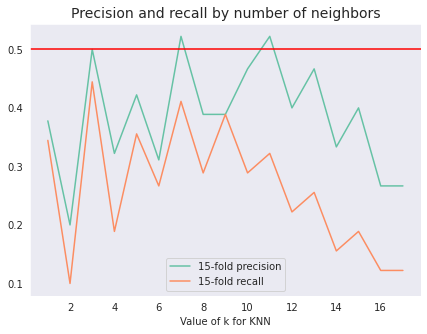

15-fold precision of the ensemble: 0.378
15-fold recall of the ensemble: 0.289
15-fold accuracy of the ensemble: 0.887

The following 13 adult males are predicted to be concered:

The following 12 adult males are predicted to live:


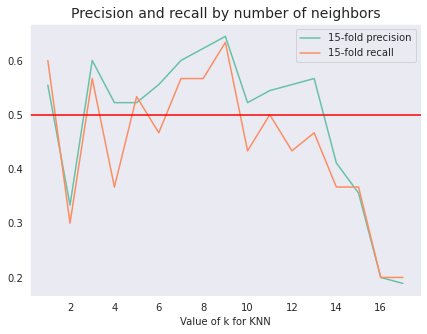

15-fold precision of the ensemble: 0.678
15-fold recall of the ensemble: 0.633
15-fold accuracy of the ensemble: 0.881

The following 7 adult females are predicted to be concered:


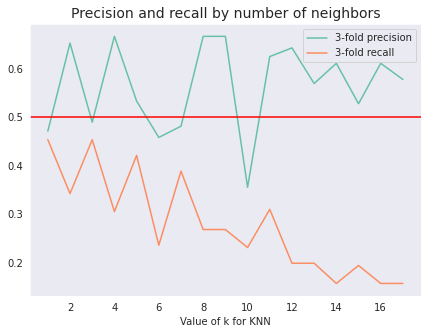

5-fold precision of the ensemble: 0.644
5-fold recall of the ensemble: 0.306
5-fold accuracy of the ensemble: 0.842

The following 10 adult females are predicted to live:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# -*- coding: utf-8 -*-
"""June8_2100_0.856_2nd_score_in_270_GCI_2022_summer_members.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1Mm-qPh90iqPZaxAjupRFeDOMOVJmXBoq

#5種類の手法による推計が異なる部分と似たレコードのTrainに絞り込み、異なる部分のみのtestについて推計し、top２手法による推計が一致する部分はそれを採用する。

top2手法とはKaggle.comのディスカッションから入手した下記フォーク元１及びフォーク元２により算出した結果0.838のこと。

注意）Kaggleではsurvivedを推計するが、GCI 2022 summerでは 1-survived=Perishedを推計する。

本スクリプトでは、データ入力部分及び出力部分でPerishedを利用するが、大半の部分ではSurvivedを利用している。

**あらかじめdata.csv,** **5つの結果ファイルをアップロードしておく。** 現在はGoogle Drive上で公開したurlから取得可能

フォーク元１　のSurvivedをPerishedに入れ替えるなど前後の手続きによりMay30_urlのデータを作成

May30_urlのデータを作成するためのスクリプトはこちら Google Drive上で公開https://drive.google.com/file/d/1xwyhqNkAAyUoPuUOysuuZNwI26Q4Fqeq/view?usp=sharing

フォーク元１　https://www.kaggle.com/code/mviola/titanic-wcg-knns-ensemble-0-82775-top-1/notebook


Titanic WCG + KNNs Ensemble [0.82775] (top 1%)
Python · Titanic - Machine Learning from Disaster

フォーク元１ で加工したデータ部分をdata.csvとしてアップロード　ただし、欠損値補間などは独自処理済み

data.csvを作成するためのスクリプトはこちら Google Drive上で公開 https://drive.google.com/file/d/1lXy-9gp9Y4q5nUHrXoQowDHWPwDkPZD-/view?usp=sharing

フォーク元２はRのnotebookなので、データの入手先、結果のSurvivedをPerishedに入れ替えるなど前後の手続きをRに付加し実行した結果ファイルをアップロードしたものがJune02_url

June02_urlのデータを作成するためのＲスクリプトはこちら Google Drive上で公開https://drive.google.com/file/d/1RhfQzm2cI4wzlML5mP09pfZm-d5TBe3R/view?usp=sharing

フォーク元２　
https://www.kaggle.com/code/cdeotte/titanic-wcg-xgboost-0-84688

ir,rfc,mlpcについてはGCIのProfessionalを実行した結果をアップロードしたもの

lr,rfc,mlpcのデータを作成するためのスクリプトはこちら Google Drive上で公開https://drive.google.com/file/d/1kuF6NEyUbc2CZMd594V3XsZfUjnAHvQE/view?usp=sharing
"""

# Commented out IPython magic to ensure Python compatibility.
from google.colab import drive
#drive.mount('/content/drive')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
sns.set_style('dark')
sns.set_palette('Set2')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

"""We first load train and test data and join the two dataframes as it will be much easier to perform all our next operations."""

# 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
# データの読み込み方がわからない方は、別途配布している、GoogleColabにおけるドライブのマウントの仕方、と、Google Drive上でのフォルダ構造の説明のpdfファイルをご覧ください。
#train_url ='https://drive.google.com/uc?id=10CDxSTdXdtwysb3OLRg4Opj4WdKRBcvP'
#test_url = 'https://drive.google.com/uc?id=1hlbby9U7-ZYhGkl9E1jQ4Un1SFpqLJCJ'
#gender_url = 'https://drive.google.com/uc?id=1bHQBrIsnGawXqoSp6QqOt57oaDY81s_F'

#df = pd.read_csv(train_url)
#df_test = pd.read_csv(test_url)
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# trainのレコード数 891
len_train = len(df)

# testのレコード数
len_test = len(df_test)

# 全体のレコード数 1309
len_all = len_test+len_train

# 個人作成データのGoogle ドライブ　データ保存場所
#data_url = 'https://drive.google.com/uc?id=1-NgrUrVwgqT5ImAoDp1maBfyPKV9mclg'
#June02_url = 'https://drive.google.com/uc?id=1TZzk7VZpUuRWPWLH_dH55VBGJsTA_Gm4'
#May30_url = 'https://drive.google.com/uc?id=1vRmhDY07Xfkez_OnrZx4Q-bOUr2kFwRc'
#ir_url = 'https://drive.google.com/uc?id=1c3VnaUbQKKn1UpYdi616Heipev-jgmn4'
#rfc_url = 'https://drive.google.com/uc?id=19ffCRRzmiYnNke0lCNbtncTIlLq_ZRNe'
#mlpc_url = 'https://drive.google.com/uc?id=1yYR1WfEk-euI0wT40uaVzIqj0Jx2uogF'
#June05_085_url = 'https://drive.google.com/uc?id=1Xid4sYhCyzyvhGhKi7NMhfUNxAww8XZ3'

# read 5 different results
result1 = pd.read_csv('June2_submission.csv')
#result1 = pd.read_csv(June02_url)

result2 = pd.read_csv('May30_submission.csv')
#result2 = pd.read_csv(May30_url)
result3 = pd.read_csv('lr_submission.csv')
#result3 = pd.read_csv(ir_url)
result4 = pd.read_csv('rfc_submission.csv')
#result4 = pd.read_csv(rfc_url)
result5 = pd.read_csv('mlpc_submission.csv')
#result5 = pd.read_csv(mlpc_url)
# best score now 0.85は読み込むが当面使わない
#result6 = pd.read_csv(June05_085_url)
survived = pd.DataFrame ({'Predict':1 - result1['Perished'] ,'PassengerId':range(len_train,len_all)})

# read data

data = pd.read_csv('data.csv')
#data = pd.read_csv(data_url)

"""# 5つの推計結果の違うところを決定する

"""

data.sort_values(by='PassengerId',inplace=True)
data = data.reset_index(drop=True)
data.drop('Predict',axis=1)
pd.merge(data,survived,on='PassengerId',how='left')
train_data = data.iloc[0:len_train,:]

#type(data.loc[len_train:,'Predict'])

#data.loc[len_train:,'Predict']

result = pd.concat([result1,result2,result3,result4,result5],axis=1).set_axis(['PassengerId',
                                                                               'Perished1',
                                                                               'Pid2',
                                                                               'Perished2',
                                                                               'Pid3',
                                                                               'Perished3',
                                                                               'Pid4',
                                                                               'Perished4',
                                                                               'Pid5',
                                                                               'Perished5'
                                                                               ], axis = 1)

result = result.loc[:,['PassengerId','Perished1','Perished2','Perished3','Perished4','Perished5']]

# PassengerIdをstringに

result.loc[:,'PassengerId']=result.loc[:,'PassengerId'].astype(str)
data.loc[:,'PassengerId']=data.loc[:,'PassengerId'].astype(str)

result.loc[:,'same_records'] =((result.Perished1==result.Perished2) & 
                (result.Perished1==result.Perished3) &
                (result.Perished1==result.Perished4) &
                (result.Perished1==result.Perished5))
result.loc[:,'Difference'] = ~result.loc[:,'same_records'].astype(int) + 2

result.loc[:,'top2_same_records'] =((result.Perished1 == result.Perished2) )
result.loc[:,'top2_Difference'] = ~result.loc[:,'top2_same_records'].astype(int) + 2

#result.loc[:,'top2_Difference'].describe()

#result.loc[result['top2_Difference']==1,:]

#result.loc[result['top2_Difference']==0,:]

# Perished1を生存者に反転して、top2の共通部分として利用する。
result.loc[:,'Perished1'] = 1 - result.loc[:,'Perished1']
result_tmp = result.loc[:,['PassengerId','Difference','top2_Difference','Perished1']]

target = pd.merge(data,result_tmp,on='PassengerId',how='left')

# now we get 'same_records'=(True,False) on test and NaN on train data

#target.loc[target['Difference']==1,:]

# Our aim is to extract 'same_records'=False data from train data

target.columns

# Isolating adult males in train and test set
test_male_ex = target[0:len_train].loc[target.Sex=='male' ]
train_male_ex = target[len_train:len_all].loc[target.Sex=='male']

cols = ['PassengerId', 'Name', 'Pfare', 'Pclass', 'Embarked', 'Age','Ticket_frequency', 'middle', 'Family', 'FCabin']
y_m = train_male_ex['Difference'].astype(int)
features = ['Pfare', 'Pclass', 'Embarked', 'Age','Ticket_frequency', 'middle', 'Family', 'FCabin']
X_m = train_male_ex[features]

numerical_cols = ['Pfare']
categorical_cols = ['Pclass', 'Embarked', 'Age','Ticket_frequency', 'middle', 'Family', 'FCabin']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

precision_m = []
recall_m = []

for k in range(1,18):
    pipeline1 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    precision_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean())
    recall_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean())
    
k_range = range(1,18)
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_m, label='15-fold precision')
plt.plot(k_range, recall_m, label='15-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

m1 = KNeighborsClassifier(n_neighbors=3)
m2 = KNeighborsClassifier(n_neighbors=5)
m3 = KNeighborsClassifier(n_neighbors=77)
# Preprocessing is the same as before
male_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting',VotingClassifier([
        ('m1', m1), ('m2', m2), ('m3', m3)]))
])
print('15-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean()))
print('15-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean()))
print('15-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1).mean()))
# Fit model and make predictions
male_pipeline.fit(X_m, y_m)
learn_train_m = male_pipeline.predict(X_m)
X_test_m = test_male_ex[features]
predictions_m_ex = male_pipeline.predict(X_test_m)
print('\nThe following 13 adult males are predicted to be concered:')
#test_male_ex.loc[(predictions_m_ex==1), cols]

# 13cell is the train data
new_train_male = target[0:len_train].loc[target.Sex=='male' ].loc[predictions_m_ex==1, :]
new_test_male = data.loc[len_train:len_all].loc[(data.Sex=='male') & (target.Difference==1)]

cols = ['PassengerId', 'Name', 'Pfare', 'Pclass', 'Age','Ticket_frequency']
target_xgboost = new_train_male['Survived']
features = ['Pfare', 'Pclass', 'Age','Ticket_frequency']
data_xgboost = new_train_male[features]

numerical_cols = ['Pfare']
categorical_cols = [ 'Pclass',  'Age','Ticket_frequency']

# インポート
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(
    data_xgboost, target_xgboost, random_state=66)

# 決定木とAdaBoostRegressorのパラメータ設定
models = {
    'tree': DecisionTreeRegressor(random_state=0),
    'AdaBoost': AdaBoostRegressor(DecisionTreeRegressor(), random_state=0) 
}

# モデル構築
scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'train_score')] = model.score(X_train, y_train)
    scores[(model_name, 'test_score')] = model.score(X_test, y_test)

# 結果を表示
pd.Series(scores).unstack()

X_test_m = new_test_male[features]
predictions_m = model.predict(X_test_m)
print('\nThe following 12 adult males are predicted to live:')
#new_test_male.loc[(predictions_m==1), cols]

#print(predictions_m)

data.loc[len_train:len_all, 'Predict'].loc[(data.Sex=='male') & (target.Difference==1)] = predictions_m
data.loc[len_train:len_all, ['PassengerId','Predict']].loc[data.Sex=='male' ].loc[target.Difference==1]


# top2の一致する場所についてはtop2の結果で上書き
data.loc[len_train:len_all, 'Predict'].loc[(data.Sex=='male') & (target.top2_Difference==0)] = target.loc[(data.Sex=='male') & (target.top2_Difference==0),'Perished1']

#data.loc[len_train:len_all, ['PassengerId','Predict']].loc[data.Sex=='male' ].loc[target.Difference==1]

"""# 女性についても同様に"""

# Isolating females in train and test set
test_female_ex = target[0:len_train].loc[target.Sex=='female' ]
train_female_ex = target[len_train:len_all].loc[(target.Sex=='female') & (target.Difference.notna())]

cols = ['PassengerId', 'Name', 'Pfare', 'Pclass', 'Embarked', 'Age','Ticket_frequency', 'middle', 'Family', 'FCabin']
y_f = train_female_ex['Difference'].astype(int)
features = ['Pfare', 'Pclass', 'Embarked', 'Age','Ticket_frequency', 'middle', 'Family', 'FCabin']
X_f = train_female_ex[features]

numerical_cols = ['Pfare']
categorical_cols = ['Pclass', 'Embarked', 'Age','Ticket_frequency', 'middle', 'Family', 'FCabin']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

precision_f = []
recall_f = []

for k in range(1,18):
    pipeline1 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    precision_f.append(cross_val_score(pipeline1, X_f, y_f, cv=15, n_jobs=-1, scoring='precision').mean())
    recall_f.append(cross_val_score(pipeline1, X_f, y_f, cv=15, n_jobs=-1, scoring='recall').mean())
    
k_range = range(1,18)
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_f, label='15-fold precision')
plt.plot(k_range, recall_f, label='15-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

m1 = KNeighborsClassifier(n_neighbors=3)
m2 = KNeighborsClassifier(n_neighbors=9)
m3 = KNeighborsClassifier(n_neighbors=13)
# Preprocessing is the same as before
female_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting',VotingClassifier([
        ('m1', m1), ('m2', m2), ('m3', m3)]))
])
print('15-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=15, n_jobs=-1, scoring='precision').mean()))
print('15-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=15, n_jobs=-1, scoring='recall').mean()))
print('15-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=15, n_jobs=-1).mean()))
# Fit model and make predictions
female_pipeline.fit(X_f, y_f)
learn_train_f = female_pipeline.predict(X_f)
X_test_f = test_female_ex[features]
predictions_f_ex = female_pipeline.predict(X_test_f)
print('\nThe following 7 adult females are predicted to be concered:')
#test_female_ex.loc[(predictions_f_ex==1), cols]

# 7cell is the train data
new_train_female = target[0:len_train].loc[target.Sex=='female' ].loc[predictions_f_ex==1, :]
new_test_female = data.loc[len_train:len_all].loc[(data.Sex=='female') & (target.Difference==1)]

cols = ['PassengerId', 'Name', 'Pfare', 'Pclass', 'Embarked', 'Age','Ticket_frequency', 'middle', 'Family', 'FCabin']
y_m = new_train_female['Survived']
features = ['Pfare', 'Pclass', 'Embarked', 'Age','Ticket_frequency', 'middle', 'Family', 'FCabin']
X_m = new_train_female[features]

numerical_cols = ['Pfare']
categorical_cols = ['Pclass', 'Embarked', 'Age','Ticket_frequency', 'middle', 'Family', 'FCabin']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

precision_f = []
recall_f = []

for k in range(1,18):
    pipeline1 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    precision_f.append(cross_val_score(pipeline1, X_f, y_f, cv=3, n_jobs=-1, scoring='precision').mean())
    recall_f.append(cross_val_score(pipeline1, X_f, y_f, cv=3, n_jobs=-1, scoring='recall').mean())
    
k_range = range(1,18)
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_f, label='3-fold precision')
plt.plot(k_range, recall_f, label='3-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

m1 = KNeighborsClassifier(n_neighbors=2)
m2 = KNeighborsClassifier(n_neighbors=4)
m3 = KNeighborsClassifier(n_neighbors=8)
# Preprocessing is the same as before
female_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting',VotingClassifier([
        ('m1', m1), ('m2', m2), ('m3', m3)]))
])
print('5-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=3, n_jobs=-1, scoring='precision').mean()))
print('5-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=3, n_jobs=-1, scoring='recall').mean()))
print('5-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(female_pipeline, X_f, y_f, cv=3, n_jobs=-1).mean()))
# Fit model and make predictions
female_pipeline.fit(X_f, y_f)
learn_train_f = female_pipeline.predict(X_f)

X_test_f = new_test_female[features]
predictions_f = female_pipeline.predict(X_test_f)
print('\nThe following 10 adult females are predicted to live:')
#new_test_female.loc[(predictions_f==1), cols]

data.loc[len_train:len_all, 'Predict'].loc[(data.Sex=='female') & (target.Difference==1)] = predictions_f

# top2の一致する場所についてはtop2の結果で上書き
data.loc[len_train:len_all, 'Predict'].loc[(data.Sex=='female') & (target.top2_Difference==0)] = target.loc[(data.Sex=='female') & (target.top2_Difference==0),'Perished1']

#target.loc[(data.Sex=='female') & (target.top2_Difference==0),['PassengerId','Perished1']]

#data.loc[len_train:len_all, ['PassengerId','Predict']].loc[(data.Sex=='female') & (target.top2_Difference==0)]

output = pd.DataFrame({'PassengerId': data[len_train:len_all].PassengerId, 'Survived': data[len_train:len_all].Predict.astype('int')})

# Google Drive・Google Colaboratoryで作業する場合
output['Perished'] = 1 - output['Survived']
output.drop('Survived', axis = 1, inplace=True)

output.loc[:,'PassengerId']=output.loc[:,'PassengerId'].astype(int)
output.sort_values(by = 'PassengerId', inplace=True)


output.to_csv('submission.csv',index=False, encoding = 'utf-8')

from google.colab import files
files.download('submission.csv')